**Downloading the Datasets (MNIST)**

In [ ]:
#required libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm


In [ ]:
#batch size to train
batch_size = 512

#noise vector size for generator
noise_vec_size = 128 

#number of steps apply to the discriminator
k = 1 

#device available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#convert the images into tensor and normalize them
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,)),])

In [ ]:
#downloading MNIST dataset
train_data = datasets.FashionMNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


Extracting /content/drive/MyDrive/Colab Notebooks/github/image_generation/input/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/github/image_generation/input/data/FashionMNIST/raw



Extracting /content/drive/MyDrive/Colab Notebooks/github/image_generation/input/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/github/image_generation/input/data/FashionMNIST/raw



Extracting /content/drive/MyDrive/Colab Notebooks/github/image_generation/input/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/github/image_generation/input/data/FashionMNIST/raw



Extracting /content/drive/MyDrive/Colab Notebooks/github/image_generation/input/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/github/image_generation/input/data/FashionMNIST/raw
Processing...
Done!


**Let's build the model!**

In [ ]:
#generator 
class generator(nn.Module):
    def __init__(self,noise_vec_size):
        super(generator,self).__init__()
        
        #size of noise vector
        self.noise_vec_size=noise_vec_size
        self.generator_layer=nn.Sequential(
            #layer 1- linear layer 
            nn.Linear(self.noise_vec_size,256),
            #activation function
            nn.LeakyReLU(),
            
            #layer 2- linear layer
            nn.Linear(256,512),
            #activation function
            nn.LeakyReLU(),

            #layer 3- linear layer
            nn.Linear(512,1024),
            #activation function
            nn.LeakyReLU(),

            #layer 4- linear layer
            nn.Linear(1024,784),
            #activation function
            nn.Tanh(),
        )
    
    #forward pass
    def forward(self,input_x):
        #forward pass of the generator
        forward_layer=self.generator_layer(input_x)
        #reshaping
        forward_layer=forward_layer.view(-1,1,28,28)
        return forward_layer

In [ ]:
generator_model=generator(noise_vec_size).to(device)

In [ ]:
generator_model

generator(
  (generator_layer): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [ ]:
#discriminator
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator,self).__init__()
        #input dimension for discriminator
        self.input_dim=784

        self.discriminator_layer=nn.Sequential(
                #layer 1- linear layer 
                nn.Linear(self.input_dim,1024),
                #activation function
                nn.LeakyReLU(),
                #randomly zeroes some of the elements of the input tensor with probability 0.3
                nn.Dropout(0.3),
                
                #layer 2- linear layer 
                nn.Linear(1024,512),
                #activation function
                nn.LeakyReLU(),
                #randomly zeroes some of the elements of the input tensor with probability 0.3
                nn.Dropout(0.3),
                
                #layer 3- linear layer 
                nn.Linear(512,256),
                #activation function
                nn.LeakyReLU(),
                #randomly zeroes some of the elements of the input tensor with probability 0.3
                nn.Dropout(0.3),
                
                #layer 4- linear layer
                nn.Linear(256,1),
                #activation function
                nn.Sigmoid(),
        )
    
    #forward pass
    def forward(self,input_x):
        #reshaping
        input_x=input_x.view(-1,784)
        #forward pass of the discriminator
        forward_layer=self.discriminator_layer(input_x)
        return  forward_layer

In [ ]:
discriminator_model=discriminator().to(device)

In [ ]:
discriminator_model

discriminator(
  (discriminator_layer): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.3, inplace=False)
    (9): Dropout(p=0.3, inplace=False)
    (10): Linear(in_features=256, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

In [ ]:
#optimizer for generator
optim_generator = optim.Adam(generator_model.parameters(), lr=0.0002)
#optimizer for discriminator
optim_discriminator = optim.Adam(discriminator_model.parameters(), lr=0.0002)

In [ ]:
#loss
criterion = nn.BCELoss()

In [ ]:
#to generate ones - real label
def label_real(size):
     data = torch.ones(size, 1)
     data=data.to(device)
     return data

In [ ]:
#to generate zeros - fake label
def label_fake(size):
    data = torch.zeros(size, 1)
    data=data.to(device)
    return data

In [ ]:
#training the discrimator
def train_discriminator(data_real,data_fake):
    size=data_real.size(0)
    
    #creating real label
    real_label=label_real(size)
    #creating fake label
    fake_label=label_fake(size)

    #clearing the Gradients 
    optim_discriminator.zero_grad()

    #output of discriminator with real data  
    output_real=discriminator_model(data_real)
    #loss of discriminator with real data  
    loss_real=criterion(output_real,real_label)

    #output of discriminator with fake data
    output_fake=discriminator_model(data_fake)
    #loss of discriminator with fake data  
    loss_fake=criterion(output_fake,fake_label)

    #backpropagate
    loss_real.backward()
    loss_fake.backward()

    #update the parameters
    optim_discriminator.step()

    total_loss=loss_real+loss_fake
    return total_loss

In [ ]:
#training the generator
def train_generator(data_fake):
    size=data_fake.size(0)

    #creating real label
    real_label=label_real(size)

    #clearing the Gradients 
    optim_generator.zero_grad()

    #output of discriminator with fake data
    output=discriminator_model(data_fake)
    #loss of discriminator with real data  
    loss=criterion(output,real_label)
    
    #backpropagate
    loss.backward()
    #update the parameters
    optim_generator.step()

    return loss

In [ ]:
#set the models to train
generator_model.train()
discriminator_model.train()

discriminator(
  (discriminator_layer): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.3, inplace=False)
    (9): Dropout(p=0.3, inplace=False)
    (10): Linear(in_features=256, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

In [ ]:
#function to create a random noise
def create_noise(sample_size, noise_vec_size):
    noise=torch.randn(sample_size, noise_vec_size)
    noise=noise.to(device)
    return noise

In [ ]:
losses_gen=[]
losses_dis=[]
images=[]

In [ ]:
#number of epoch
epochs = 200

for epoch in range(epochs):
    #inital loss
    loss_gen = 0.0
    loss_dis = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image,_=data
        image=image.to(device)
        size=len(image)
        for step in range(k):
            #generate fake image by generator
            data_fake=generator_model(create_noise(size,noise_vec_size)).detach()
            data_real=image
            #calculate the loss of the discriminator
            loss_dis=loss_dis + train_discriminator(data_real,data_fake)
        
        data_fake=generator_model(create_noise(size,noise_vec_size))
        #calculate the loss of the generator
        loss_gen=loss_gen + train_generator(data_fake)
    
    #total generator loss for the epoch
    epoch_loss_g = loss_gen / bi 
    #total discriminator loss for the epoch
    epoch_loss_d = loss_dis / bi 
    losses_gen.append(epoch_loss_g)
    losses_dis.append(epoch_loss_d)

    print("Epoch :",epoch)
    print("Generator loss :", epoch_loss_g, "Discriminator loss :",epoch_loss_d)



  0%|          | 0/117 [00:00<?, ?it/s]

  2%|▏         | 2/117 [00:00<00:08, 13.41it/s]

  3%|▎         | 4/117 [00:00<00:08, 13.71it/s]

  5%|▌         | 6/117 [00:00<00:07, 13.92it/s]

  7%|▋         | 8/117 [00:00<00:07, 13.88it/s]

  9%|▊         | 10/117 [00:00<00:07, 13.87it/s]

 10%|█         | 12/117 [00:00<00:07, 13.97it/s]

 12%|█▏        | 14/117 [00:01<00:07, 13.78it/s]

 14%|█▎        | 16/117 [00:01<00:07, 13.96it/s]

 15%|█▌        | 18/117 [00:01<00:07, 13.19it/s]

 17%|█▋        | 20/117 [00:01<00:07, 13.21it/s]

 19%|█▉        | 22/117 [00:01<00:07, 13.45it/s]

 21%|██        | 24/117 [00:01<00:07, 12.95it/s]

 22%|██▏       | 26/117 [00:01<00:07, 12.91it/s]

 24%|██▍       | 28/117 [00:02<00:06, 12.78it/s]

 26%|██▌       | 30/117 [00:02<00:06, 13.03it/s]

 27%|██▋       | 32/117 [00:02<00:06, 13.19it/s]

 29%|██▉       | 34/117 [00:02<00:06, 13.37it/s]

 31%|███       | 36/117 [00:02<00:06, 12.87it/s]

 32%|███▏      | 38/117 [00:02<00:06, 12.77it/s]

 34%|███▍  

Epoch : 0
Generator loss : tensor(1.7897, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.5566, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 13.30it/s]

  5%|▌         | 6/117 [00:00<00:08, 13.29it/s]

  7%|▋         | 8/117 [00:00<00:08, 13.26it/s]

  9%|▊         | 10/117 [00:00<00:07, 13.56it/s]

 10%|█         | 12/117 [00:00<00:07, 13.61it/s]

 12%|█▏        | 14/117 [00:01<00:07, 13.72it/s]

 14%|█▎        | 16/117 [00:01<00:07, 13.89it/s]

 15%|█▌        | 18/117 [00:01<00:07, 14.05it/s]

 17%|█▋        | 20/117 [00:01<00:06, 14.01it/s]

 19%|█▉        | 22/117 [00:01<00:07, 13.52it/s]

 21%|██        | 24/117 [00:01<00:06, 13.59it/s]

 22%|██▏       | 26/117 [00:01<00:06, 13.61it/s]

 24%|██▍       | 28/117 [00:02<00:06, 13.76it/s]

 26%|██▌       | 30/117 [00:02<00:06, 13.77it/s]

 27%|██▋       | 32/117 [00:02<00:06, 13.91it/s]

 29%|██▉       | 34/117 [00:02<00:05, 13.88it/s]

 31%|███       | 36/117 [00:02<00:05, 13.99it/s]

 32%|███▏      | 38/117 [00:02<00:05, 13.70it/s]

 34%|███▍      | 40/117 [00:02<00:05, 13.84it/s]

 36%|███▌      | 42/117 [00:03<00:05, 13.83it/s]

 

Epoch : 1
Generator loss : tensor(4.3152, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1828, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 12.92it/s]

  5%|▌         | 6/117 [00:00<00:08, 13.19it/s]

  7%|▋         | 8/117 [00:00<00:08, 13.26it/s]

  9%|▊         | 10/117 [00:00<00:08, 13.32it/s]

 10%|█         | 12/117 [00:00<00:07, 13.50it/s]

 12%|█▏        | 14/117 [00:01<00:07, 13.66it/s]

 14%|█▎        | 16/117 [00:01<00:07, 13.69it/s]

 15%|█▌        | 18/117 [00:01<00:07, 13.78it/s]

 17%|█▋        | 20/117 [00:01<00:07, 13.58it/s]

 19%|█▉        | 22/117 [00:01<00:06, 13.72it/s]

 21%|██        | 24/117 [00:01<00:06, 13.43it/s]

 22%|██▏       | 26/117 [00:01<00:06, 13.31it/s]

 24%|██▍       | 28/117 [00:02<00:06, 13.51it/s]

 26%|██▌       | 30/117 [00:02<00:06, 13.48it/s]

 27%|██▋       | 32/117 [00:02<00:06, 13.46it/s]

 29%|██▉       | 34/117 [00:02<00:06, 13.55it/s]

 31%|███       | 36/117 [00:02<00:06, 13.35it/s]

 32%|███▏      | 38/117 [00:02<00:06, 13.07it/s]

 34%|███▍      | 40/117 [00:02<00:05, 13.12it/s]

 36%|███▌      | 42/117 [00:03<00:05, 13.18it/s]

 

Epoch : 2
Generator loss : tensor(8.0553, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1588, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 13.11it/s]

  5%|▌         | 6/117 [00:00<00:08, 13.28it/s]

  7%|▋         | 8/117 [00:00<00:08, 13.62it/s]

  9%|▊         | 10/117 [00:00<00:07, 13.73it/s]

 10%|█         | 12/117 [00:00<00:07, 13.78it/s]

 12%|█▏        | 14/117 [00:01<00:07, 13.73it/s]

 14%|█▎        | 16/117 [00:01<00:07, 13.94it/s]

 15%|█▌        | 18/117 [00:01<00:07, 13.97it/s]

 17%|█▋        | 20/117 [00:01<00:07, 13.70it/s]

 19%|█▉        | 22/117 [00:01<00:06, 13.59it/s]

 21%|██        | 24/117 [00:01<00:06, 13.82it/s]

 22%|██▏       | 26/117 [00:01<00:06, 13.97it/s]

 24%|██▍       | 28/117 [00:02<00:06, 13.61it/s]

 26%|██▌       | 30/117 [00:02<00:06, 13.67it/s]

 27%|██▋       | 32/117 [00:02<00:06, 13.84it/s]

 29%|██▉       | 34/117 [00:02<00:05, 13.99it/s]

 31%|███       | 36/117 [00:02<00:05, 14.11it/s]

 32%|███▏      | 38/117 [00:02<00:05, 14.10it/s]

 34%|███▍      | 40/117 [00:02<00:05, 14.09it/s]

 36%|███▌      | 42/117 [00:03<00:05, 13.92it/s]

 

Epoch : 3
Generator loss : tensor(5.7795, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1986, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 13.72it/s]

  5%|▌         | 6/117 [00:00<00:08, 13.81it/s]

  7%|▋         | 8/117 [00:00<00:08, 13.07it/s]

  9%|▊         | 10/117 [00:00<00:08, 13.23it/s]

 10%|█         | 12/117 [00:00<00:07, 13.19it/s]

 12%|█▏        | 14/117 [00:01<00:07, 13.03it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.49it/s]

 15%|█▌        | 18/117 [00:01<00:07, 12.48it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.18it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.16it/s]

 21%|██        | 24/117 [00:01<00:07, 11.89it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.44it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.60it/s]

 26%|██▌       | 30/117 [00:02<00:06, 13.02it/s]

 27%|██▋       | 32/117 [00:02<00:06, 13.06it/s]

 29%|██▉       | 34/117 [00:02<00:06, 13.43it/s]

 31%|███       | 36/117 [00:02<00:06, 13.46it/s]

 32%|███▏      | 38/117 [00:02<00:05, 13.29it/s]

 34%|███▍      | 40/117 [00:03<00:05, 13.54it/s]

 36%|███▌      | 42/117 [00:03<00:05, 13.74it/s]

 

Epoch : 4
Generator loss : tensor(6.5219, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.2236, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.30it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.72it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.79it/s]

  9%|▊         | 10/117 [00:00<00:08, 13.19it/s]

 10%|█         | 12/117 [00:00<00:07, 13.13it/s]

 12%|█▏        | 14/117 [00:01<00:07, 13.48it/s]

 14%|█▎        | 16/117 [00:01<00:07, 13.19it/s]

 15%|█▌        | 18/117 [00:01<00:07, 13.53it/s]

 17%|█▋        | 20/117 [00:01<00:07, 13.74it/s]

 19%|█▉        | 22/117 [00:01<00:06, 13.68it/s]

 21%|██        | 24/117 [00:01<00:06, 13.77it/s]

 22%|██▏       | 26/117 [00:01<00:06, 13.63it/s]

 24%|██▍       | 28/117 [00:02<00:06, 13.33it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.99it/s]

 27%|██▋       | 32/117 [00:02<00:06, 13.11it/s]

 29%|██▉       | 34/117 [00:02<00:06, 13.11it/s]

 31%|███       | 36/117 [00:02<00:06, 13.26it/s]

 32%|███▏      | 38/117 [00:02<00:06, 13.05it/s]

 34%|███▍      | 40/117 [00:03<00:05, 13.17it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.25it/s]

 

Epoch : 5
Generator loss : tensor(5.4775, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1069, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:07, 14.37it/s]

  5%|▌         | 6/117 [00:00<00:07, 14.05it/s]

  7%|▋         | 8/117 [00:00<00:07, 13.88it/s]

  9%|▊         | 10/117 [00:00<00:07, 13.93it/s]

 10%|█         | 12/117 [00:00<00:07, 13.42it/s]

 12%|█▏        | 14/117 [00:01<00:07, 13.64it/s]

 14%|█▎        | 16/117 [00:01<00:07, 13.77it/s]

 15%|█▌        | 18/117 [00:01<00:07, 13.50it/s]

 17%|█▋        | 20/117 [00:01<00:07, 13.33it/s]

 19%|█▉        | 22/117 [00:01<00:07, 13.39it/s]

 21%|██        | 24/117 [00:01<00:06, 13.56it/s]

 22%|██▏       | 26/117 [00:01<00:06, 13.61it/s]

 24%|██▍       | 28/117 [00:02<00:06, 13.52it/s]

 26%|██▌       | 30/117 [00:02<00:06, 13.62it/s]

 27%|██▋       | 32/117 [00:02<00:06, 13.73it/s]

 29%|██▉       | 34/117 [00:02<00:06, 13.83it/s]

 31%|███       | 36/117 [00:02<00:06, 13.49it/s]

 32%|███▏      | 38/117 [00:02<00:05, 13.54it/s]

 34%|███▍      | 40/117 [00:02<00:05, 13.31it/s]

 36%|███▌      | 42/117 [00:03<00:05, 13.32it/s]

 

Epoch : 6
Generator loss : tensor(5.7550, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.0552, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 13.56it/s]

  5%|▌         | 6/117 [00:00<00:08, 13.73it/s]

  7%|▋         | 8/117 [00:00<00:07, 13.80it/s]

  9%|▊         | 10/117 [00:00<00:07, 13.63it/s]

 10%|█         | 12/117 [00:00<00:07, 13.75it/s]

 12%|█▏        | 14/117 [00:01<00:07, 13.76it/s]

 14%|█▎        | 16/117 [00:01<00:07, 13.46it/s]

 15%|█▌        | 18/117 [00:01<00:07, 13.29it/s]

 17%|█▋        | 20/117 [00:01<00:07, 13.12it/s]

 19%|█▉        | 22/117 [00:01<00:07, 13.15it/s]

 21%|██        | 24/117 [00:01<00:07, 13.04it/s]

 22%|██▏       | 26/117 [00:01<00:06, 13.17it/s]

 24%|██▍       | 28/117 [00:02<00:06, 13.36it/s]

 26%|██▌       | 30/117 [00:02<00:06, 13.09it/s]

 27%|██▋       | 32/117 [00:02<00:06, 13.11it/s]

 29%|██▉       | 34/117 [00:02<00:06, 13.14it/s]

 31%|███       | 36/117 [00:02<00:06, 13.15it/s]

 32%|███▏      | 38/117 [00:02<00:06, 13.06it/s]

 34%|███▍      | 40/117 [00:03<00:05, 12.90it/s]

 36%|███▌      | 42/117 [00:03<00:05, 13.17it/s]

 

Epoch : 7
Generator loss : tensor(6.0707, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1156, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 12.92it/s]

  5%|▌         | 6/117 [00:00<00:08, 13.04it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.68it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.22it/s]

 10%|█         | 12/117 [00:00<00:08, 12.35it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.39it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.21it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.33it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.59it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.92it/s]

 21%|██        | 24/117 [00:01<00:07, 12.81it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.59it/s]

 24%|██▍       | 28/117 [00:02<00:06, 12.80it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.77it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.89it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.71it/s]

 31%|███       | 36/117 [00:02<00:06, 12.81it/s]

 32%|███▏      | 38/117 [00:02<00:06, 13.00it/s]

 34%|███▍      | 40/117 [00:03<00:06, 11.60it/s]

 36%|███▌      | 42/117 [00:03<00:06, 11.68it/s]

 

Epoch : 8
Generator loss : tensor(6.3672, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1319, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.38it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.65it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.77it/s]

  9%|▊         | 10/117 [00:00<00:08, 13.00it/s]

 10%|█         | 12/117 [00:00<00:08, 12.80it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.82it/s]

 14%|█▎        | 16/117 [00:01<00:07, 12.94it/s]

 15%|█▌        | 18/117 [00:01<00:07, 13.17it/s]

 17%|█▋        | 20/117 [00:01<00:07, 13.38it/s]

 19%|█▉        | 22/117 [00:01<00:07, 13.42it/s]

 21%|██        | 24/117 [00:01<00:06, 13.50it/s]

 22%|██▏       | 26/117 [00:01<00:06, 13.28it/s]

 24%|██▍       | 28/117 [00:02<00:06, 12.89it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.69it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.75it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.75it/s]

 31%|███       | 36/117 [00:02<00:06, 12.63it/s]

 32%|███▏      | 38/117 [00:02<00:06, 12.68it/s]

 34%|███▍      | 40/117 [00:03<00:05, 12.89it/s]

 36%|███▌      | 42/117 [00:03<00:05, 13.09it/s]

 

Epoch : 9
Generator loss : tensor(5.7344, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.0852, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.37it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.70it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.66it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.79it/s]

 10%|█         | 12/117 [00:00<00:08, 12.74it/s]

 12%|█▏        | 14/117 [00:01<00:07, 12.90it/s]

 14%|█▎        | 16/117 [00:01<00:07, 12.99it/s]

 15%|█▌        | 18/117 [00:01<00:07, 13.15it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.98it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.73it/s]

 21%|██        | 24/117 [00:01<00:07, 12.66it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.60it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.21it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.38it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.45it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.40it/s]

 31%|███       | 36/117 [00:02<00:06, 12.26it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.07it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.11it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.12it/s]

 

Epoch : 10
Generator loss : tensor(5.4332, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.0895, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 12.74it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.67it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.55it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.37it/s]

 10%|█         | 12/117 [00:00<00:08, 12.49it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.49it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.59it/s]

 15%|█▌        | 18/117 [00:01<00:07, 12.67it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.78it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.55it/s]

 21%|██        | 24/117 [00:01<00:07, 12.48it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.44it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.58it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.64it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.50it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.36it/s]

 31%|███       | 36/117 [00:02<00:06, 12.29it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.45it/s]

 34%|███▍      | 40/117 [00:03<00:06, 11.89it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.08it/s]

 

Epoch : 11
Generator loss : tensor(6.0887, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.0760, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 12.67it/s]

  5%|▌         | 6/117 [00:00<00:09, 12.27it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.58it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.66it/s]

 10%|█         | 12/117 [00:00<00:08, 12.63it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.67it/s]

 14%|█▎        | 16/117 [00:01<00:07, 12.65it/s]

 15%|█▌        | 18/117 [00:01<00:07, 12.38it/s]

 17%|█▋        | 20/117 [00:01<00:08, 12.02it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.28it/s]

 21%|██        | 24/117 [00:01<00:07, 12.45it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.56it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.49it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.15it/s]

 27%|██▋       | 32/117 [00:02<00:07, 12.14it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.32it/s]

 31%|███       | 36/117 [00:02<00:06, 12.03it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.25it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.29it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.46it/s]

 

Epoch : 12
Generator loss : tensor(5.7715, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.0782, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.27it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.59it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.68it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.88it/s]

 10%|█         | 12/117 [00:00<00:08, 12.82it/s]

 12%|█▏        | 14/117 [00:01<00:07, 12.99it/s]

 14%|█▎        | 16/117 [00:01<00:07, 13.04it/s]

 15%|█▌        | 18/117 [00:01<00:07, 13.17it/s]

 17%|█▋        | 20/117 [00:01<00:07, 13.24it/s]

 19%|█▉        | 22/117 [00:01<00:07, 13.32it/s]

 21%|██        | 24/117 [00:01<00:06, 13.34it/s]

 22%|██▏       | 26/117 [00:01<00:06, 13.14it/s]

 24%|██▍       | 28/117 [00:02<00:06, 13.22it/s]

 26%|██▌       | 30/117 [00:02<00:06, 13.19it/s]

 27%|██▋       | 32/117 [00:02<00:06, 13.24it/s]

 29%|██▉       | 34/117 [00:02<00:06, 13.35it/s]

 31%|███       | 36/117 [00:02<00:06, 12.90it/s]

 32%|███▏      | 38/117 [00:02<00:06, 13.06it/s]

 34%|███▍      | 40/117 [00:03<00:05, 12.89it/s]

 36%|███▌      | 42/117 [00:03<00:05, 12.97it/s]

 

Epoch : 13
Generator loss : tensor(5.4310, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.0678, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 12.88it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.68it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.83it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.62it/s]

 10%|█         | 12/117 [00:00<00:08, 12.76it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.84it/s]

 14%|█▎        | 16/117 [00:01<00:07, 12.97it/s]

 15%|█▌        | 18/117 [00:01<00:07, 12.80it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.93it/s]

 19%|█▉        | 22/117 [00:01<00:07, 13.07it/s]

 21%|██        | 24/117 [00:01<00:07, 13.02it/s]

 22%|██▏       | 26/117 [00:02<00:06, 13.23it/s]

 24%|██▍       | 28/117 [00:02<00:06, 13.19it/s]

 26%|██▌       | 30/117 [00:02<00:06, 13.22it/s]

 27%|██▋       | 32/117 [00:02<00:06, 13.11it/s]

 29%|██▉       | 34/117 [00:02<00:06, 13.13it/s]

 31%|███       | 36/117 [00:02<00:06, 11.70it/s]

 32%|███▏      | 38/117 [00:02<00:06, 12.14it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.52it/s]

 36%|███▌      | 42/117 [00:03<00:05, 12.86it/s]

 

Epoch : 14
Generator loss : tensor(5.9915, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.0764, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 12.68it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.65it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.69it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.95it/s]

 10%|█         | 12/117 [00:00<00:08, 13.08it/s]

 12%|█▏        | 14/117 [00:01<00:07, 13.04it/s]

 14%|█▎        | 16/117 [00:01<00:07, 13.20it/s]

 15%|█▌        | 18/117 [00:01<00:07, 12.86it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.94it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.82it/s]

 21%|██        | 24/117 [00:01<00:07, 13.02it/s]

 22%|██▏       | 26/117 [00:02<00:06, 13.11it/s]

 24%|██▍       | 28/117 [00:02<00:06, 13.11it/s]

 26%|██▌       | 30/117 [00:02<00:06, 13.23it/s]

 27%|██▋       | 32/117 [00:02<00:06, 13.13it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.90it/s]

 31%|███       | 36/117 [00:02<00:06, 13.02it/s]

 32%|███▏      | 38/117 [00:02<00:06, 13.15it/s]

 34%|███▍      | 40/117 [00:03<00:05, 12.99it/s]

 36%|███▌      | 42/117 [00:03<00:05, 13.08it/s]

 

Epoch : 15
Generator loss : tensor(6.3452, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.0666, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.41it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.55it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.84it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.92it/s]

 10%|█         | 12/117 [00:00<00:08, 13.05it/s]

 12%|█▏        | 14/117 [00:01<00:07, 12.90it/s]

 14%|█▎        | 16/117 [00:01<00:07, 13.09it/s]

 15%|█▌        | 18/117 [00:01<00:07, 12.75it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.70it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.98it/s]

 21%|██        | 24/117 [00:01<00:07, 13.05it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.47it/s]

 24%|██▍       | 28/117 [00:02<00:06, 12.75it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.89it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.81it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.79it/s]

 31%|███       | 36/117 [00:02<00:06, 12.96it/s]

 32%|███▏      | 38/117 [00:02<00:06, 12.70it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.69it/s]

 36%|███▌      | 42/117 [00:03<00:05, 12.93it/s]

 

Epoch : 16
Generator loss : tensor(6.0166, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.0973, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 13.05it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.92it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.90it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.82it/s]

 10%|█         | 12/117 [00:00<00:08, 12.95it/s]

 12%|█▏        | 14/117 [00:01<00:07, 13.03it/s]

 14%|█▎        | 16/117 [00:01<00:07, 13.06it/s]

 15%|█▌        | 18/117 [00:01<00:07, 13.16it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.97it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.74it/s]

 21%|██        | 24/117 [00:01<00:07, 12.93it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.94it/s]

 24%|██▍       | 28/117 [00:02<00:06, 13.07it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.85it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.77it/s]

 29%|██▉       | 34/117 [00:02<00:07, 11.63it/s]

 31%|███       | 36/117 [00:02<00:06, 11.83it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.22it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.39it/s]

 36%|███▌      | 42/117 [00:03<00:05, 12.61it/s]

 

Epoch : 17
Generator loss : tensor(5.3734, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1173, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 12.66it/s]

  4%|▍         | 5/117 [00:00<00:09, 11.37it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.84it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.29it/s]

  9%|▊         | 10/117 [00:00<00:09, 11.81it/s]

 10%|█         | 12/117 [00:01<00:08, 11.93it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.31it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.52it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.05it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.28it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.59it/s]

 21%|██        | 24/117 [00:01<00:07, 12.80it/s]

 22%|██▏       | 26/117 [00:02<00:06, 13.05it/s]

 24%|██▍       | 28/117 [00:02<00:06, 12.95it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.57it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.67it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.60it/s]

 31%|███       | 36/117 [00:02<00:06, 12.78it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.91it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.76it/s]

 3

Epoch : 18
Generator loss : tensor(5.9425, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1223, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.44it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.50it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.36it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.44it/s]

 10%|█         | 12/117 [00:00<00:08, 12.72it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.83it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.53it/s]

 15%|█▌        | 18/117 [00:01<00:07, 12.53it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.15it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.21it/s]

 21%|██        | 24/117 [00:01<00:07, 12.35it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.15it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.11it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.42it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.54it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.75it/s]

 31%|███       | 36/117 [00:02<00:06, 12.61it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.81it/s]

 34%|███▍      | 40/117 [00:03<00:05, 12.85it/s]

 36%|███▌      | 42/117 [00:03<00:05, 12.69it/s]

 

Epoch : 19
Generator loss : tensor(5.6830, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1298, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11, 10.27it/s]

  4%|▍         | 5/117 [00:00<00:10, 11.04it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.45it/s]

  8%|▊         | 9/117 [00:00<00:08, 12.02it/s]

  9%|▉         | 11/117 [00:00<00:08, 12.32it/s]

 11%|█         | 13/117 [00:01<00:08, 12.58it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.26it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.33it/s]

 16%|█▌        | 19/117 [00:01<00:07, 12.62it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.83it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.90it/s]

 21%|██▏       | 25/117 [00:01<00:07, 12.83it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.46it/s]

 25%|██▍       | 29/117 [00:02<00:06, 12.62it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.68it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.15it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.17it/s]

 32%|███▏      | 37/117 [00:02<00:06, 12.13it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.16it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.39it/s]

 3

Epoch : 20
Generator loss : tensor(5.5829, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1349, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 12.57it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.54it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.90it/s]

  9%|▊         | 10/117 [00:00<00:08, 13.23it/s]

 10%|█         | 12/117 [00:00<00:08, 13.11it/s]

 12%|█▏        | 14/117 [00:01<00:07, 13.10it/s]

 14%|█▎        | 16/117 [00:01<00:07, 13.05it/s]

 15%|█▌        | 18/117 [00:01<00:07, 13.36it/s]

 17%|█▋        | 20/117 [00:01<00:07, 13.44it/s]

 19%|█▉        | 22/117 [00:01<00:07, 13.35it/s]

 21%|██        | 24/117 [00:01<00:06, 13.38it/s]

 22%|██▏       | 26/117 [00:01<00:06, 13.26it/s]

 24%|██▍       | 28/117 [00:02<00:06, 13.17it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.79it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.55it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.47it/s]

 31%|███       | 36/117 [00:02<00:06, 12.62it/s]

 32%|███▏      | 38/117 [00:02<00:06, 12.76it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.55it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.28it/s]

 

Epoch : 21
Generator loss : tensor(5.7280, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1315, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 13.12it/s]

  5%|▌         | 6/117 [00:00<00:08, 13.35it/s]

  7%|▋         | 8/117 [00:00<00:08, 13.38it/s]

  9%|▊         | 10/117 [00:00<00:07, 13.43it/s]

 10%|█         | 12/117 [00:00<00:07, 13.18it/s]

 12%|█▏        | 14/117 [00:01<00:07, 13.14it/s]

 14%|█▎        | 16/117 [00:01<00:07, 13.32it/s]

 15%|█▌        | 18/117 [00:01<00:07, 13.38it/s]

 17%|█▋        | 20/117 [00:01<00:07, 13.29it/s]

 19%|█▉        | 22/117 [00:01<00:07, 13.24it/s]

 21%|██        | 24/117 [00:01<00:07, 13.08it/s]

 22%|██▏       | 26/117 [00:01<00:07, 12.52it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.60it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.57it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.84it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.99it/s]

 31%|███       | 36/117 [00:02<00:06, 12.96it/s]

 32%|███▏      | 38/117 [00:02<00:06, 13.03it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.81it/s]

 36%|███▌      | 42/117 [00:03<00:05, 12.97it/s]

 

Epoch : 22
Generator loss : tensor(5.8131, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1459, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.25it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.65it/s]

  7%|▋         | 8/117 [00:00<00:08, 13.04it/s]

  9%|▊         | 10/117 [00:00<00:08, 13.22it/s]

 10%|█         | 12/117 [00:00<00:07, 13.18it/s]

 12%|█▏        | 14/117 [00:01<00:07, 13.32it/s]

 14%|█▎        | 16/117 [00:01<00:07, 13.25it/s]

 15%|█▌        | 18/117 [00:01<00:07, 13.37it/s]

 17%|█▋        | 20/117 [00:01<00:07, 13.19it/s]

 19%|█▉        | 22/117 [00:01<00:07, 13.15it/s]

 21%|██        | 24/117 [00:01<00:07, 12.90it/s]

 22%|██▏       | 26/117 [00:01<00:07, 12.98it/s]

 24%|██▍       | 28/117 [00:02<00:06, 13.00it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.89it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.30it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.60it/s]

 31%|███       | 36/117 [00:02<00:06, 12.82it/s]

 32%|███▏      | 38/117 [00:02<00:06, 12.67it/s]

 34%|███▍      | 40/117 [00:03<00:05, 12.90it/s]

 36%|███▌      | 42/117 [00:03<00:05, 13.08it/s]

 

Epoch : 23
Generator loss : tensor(5.1217, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1791, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.30it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.69it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.91it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.51it/s]

 10%|█         | 12/117 [00:00<00:08, 12.44it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.50it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.25it/s]

 15%|█▌        | 18/117 [00:01<00:07, 12.43it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.67it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.74it/s]

 21%|██        | 24/117 [00:01<00:07, 12.72it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.77it/s]

 24%|██▍       | 28/117 [00:02<00:06, 12.93it/s]

 26%|██▌       | 30/117 [00:02<00:06, 13.02it/s]

 27%|██▋       | 32/117 [00:02<00:06, 13.04it/s]

 29%|██▉       | 34/117 [00:02<00:06, 13.01it/s]

 31%|███       | 36/117 [00:02<00:06, 13.19it/s]

 32%|███▏      | 38/117 [00:02<00:06, 12.69it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.52it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.48it/s]

 

Epoch : 24
Generator loss : tensor(5.0128, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1742, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.71it/s]

  5%|▌         | 6/117 [00:00<00:09, 12.21it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.35it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.53it/s]

 10%|█         | 12/117 [00:00<00:08, 12.66it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.87it/s]

 14%|█▎        | 16/117 [00:01<00:07, 12.72it/s]

 15%|█▌        | 18/117 [00:01<00:07, 13.02it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.94it/s]

 19%|█▉        | 22/117 [00:01<00:07, 13.15it/s]

 21%|██        | 24/117 [00:01<00:07, 13.06it/s]

 22%|██▏       | 26/117 [00:02<00:06, 13.13it/s]

 24%|██▍       | 28/117 [00:02<00:06, 13.00it/s]

 26%|██▌       | 30/117 [00:02<00:06, 13.08it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.58it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.76it/s]

 31%|███       | 36/117 [00:02<00:06, 12.68it/s]

 32%|███▏      | 38/117 [00:02<00:06, 12.66it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.64it/s]

 36%|███▌      | 42/117 [00:03<00:05, 12.60it/s]

 

Epoch : 25
Generator loss : tensor(5.2836, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1665, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.14it/s]

  5%|▌         | 6/117 [00:00<00:09, 12.32it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.14it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.25it/s]

 10%|█         | 12/117 [00:00<00:08, 12.52it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.63it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.49it/s]

 15%|█▌        | 18/117 [00:01<00:07, 12.68it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.87it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.94it/s]

 21%|██        | 24/117 [00:01<00:07, 13.09it/s]

 22%|██▏       | 26/117 [00:02<00:06, 13.04it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.80it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.06it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.44it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.16it/s]

 31%|███       | 36/117 [00:02<00:06, 11.68it/s]

 32%|███▏      | 38/117 [00:03<00:07, 10.62it/s]

 34%|███▍      | 40/117 [00:03<00:07, 10.69it/s]

 36%|███▌      | 42/117 [00:03<00:06, 11.03it/s]

 

Epoch : 26
Generator loss : tensor(4.8779, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1712, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 10.57it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.92it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.10it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.44it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.64it/s]

 11%|█         | 13/117 [00:01<00:08, 11.63it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.05it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.39it/s]

 16%|█▌        | 19/117 [00:01<00:07, 12.58it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.35it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.22it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.19it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.27it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.12it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.03it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.94it/s]

 30%|██▉       | 35/117 [00:02<00:06, 11.86it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.02it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.88it/s]

 35%|███▌      | 41/117 [00:03<00:06, 11.89it/s]

 3

Epoch : 27
Generator loss : tensor(4.9185, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1712, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.84it/s]

  5%|▌         | 6/117 [00:00<00:09, 12.27it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.23it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.22it/s]

 10%|█         | 12/117 [00:00<00:08, 12.33it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.46it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.38it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.07it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.96it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.22it/s]

 21%|██        | 24/117 [00:01<00:07, 12.04it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.38it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.21it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.32it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.45it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.27it/s]

 31%|███       | 36/117 [00:02<00:06, 12.48it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.45it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.33it/s]

 36%|███▌      | 42/117 [00:03<00:06, 11.98it/s]

 

Epoch : 28
Generator loss : tensor(4.6551, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1941, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.97it/s]

  5%|▌         | 6/117 [00:00<00:09, 12.06it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.86it/s]

  9%|▊         | 10/117 [00:00<00:09, 11.84it/s]

 10%|█         | 12/117 [00:01<00:08, 11.77it/s]

 12%|█▏        | 14/117 [00:01<00:08, 11.96it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.17it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.21it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.21it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.25it/s]

 21%|██        | 24/117 [00:01<00:07, 12.35it/s]

 22%|██▏       | 26/117 [00:02<00:08, 11.16it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.71it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.89it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.17it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.07it/s]

 31%|███       | 36/117 [00:03<00:06, 11.97it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.06it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.10it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.03it/s]

 

Epoch : 29
Generator loss : tensor(4.8737, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.1808, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:10, 11.21it/s]

  5%|▌         | 6/117 [00:00<00:09, 11.70it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.99it/s]

  9%|▊         | 10/117 [00:00<00:09, 11.89it/s]

 10%|█         | 12/117 [00:00<00:08, 12.14it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.01it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.07it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.08it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.95it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.16it/s]

 21%|██        | 24/117 [00:01<00:07, 12.18it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.42it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.35it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.25it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.42it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.39it/s]

 31%|███       | 36/117 [00:02<00:06, 12.52it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.21it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.36it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.15it/s]

 

Epoch : 30
Generator loss : tensor(4.5834, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.2113, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.08it/s]

  5%|▌         | 6/117 [00:00<00:09, 12.22it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.43it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.69it/s]

 10%|█         | 12/117 [00:00<00:08, 12.63it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.58it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.56it/s]

 15%|█▌        | 18/117 [00:01<00:07, 12.73it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.79it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.94it/s]

 21%|██        | 24/117 [00:01<00:07, 12.84it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.70it/s]

 24%|██▍       | 28/117 [00:02<00:06, 12.83it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.57it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.75it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.62it/s]

 31%|███       | 36/117 [00:02<00:06, 12.22it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.47it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.52it/s]

 36%|███▌      | 42/117 [00:03<00:05, 12.70it/s]

 

Epoch : 31
Generator loss : tensor(4.7627, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.2098, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.79it/s]

  5%|▌         | 6/117 [00:00<00:09, 12.12it/s]

  7%|▋         | 8/117 [00:00<00:09, 12.07it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.19it/s]

 10%|█         | 12/117 [00:00<00:08, 12.40it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.43it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.42it/s]

 15%|█▌        | 18/117 [00:01<00:07, 12.63it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.48it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.50it/s]

 21%|██        | 24/117 [00:01<00:08, 11.59it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.79it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.08it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.23it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.86it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.31it/s]

 31%|███       | 36/117 [00:02<00:06, 12.32it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.40it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.46it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.20it/s]

 

Epoch : 32
Generator loss : tensor(4.5424, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.2190, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11, 10.01it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.73it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.96it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.47it/s]

  9%|▉         | 11/117 [00:00<00:08, 11.83it/s]

 11%|█         | 13/117 [00:01<00:08, 11.92it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.91it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.18it/s]

 16%|█▌        | 19/117 [00:01<00:07, 12.31it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.63it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.43it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.99it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.59it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.64it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.97it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.96it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.16it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.12it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.27it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.39it/s]

 3

Epoch : 33
Generator loss : tensor(4.5774, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.2101, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.83it/s]

  5%|▌         | 6/117 [00:00<00:09, 11.87it/s]

  7%|▋         | 8/117 [00:00<00:09, 12.03it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.07it/s]

 10%|█         | 12/117 [00:00<00:08, 12.30it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.26it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.25it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.94it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.99it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.07it/s]

 21%|██        | 24/117 [00:01<00:07, 12.33it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.23it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.45it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.45it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.57it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.36it/s]

 31%|███       | 36/117 [00:02<00:06, 12.49it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.67it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.40it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.45it/s]

 

Epoch : 34
Generator loss : tensor(4.7387, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.2223, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 10.59it/s]

  4%|▍         | 5/117 [00:00<00:10, 11.17it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.52it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.81it/s]

  9%|▉         | 11/117 [00:00<00:08, 11.91it/s]

 11%|█         | 13/117 [00:01<00:08, 12.06it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.25it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.26it/s]

 16%|█▌        | 19/117 [00:01<00:07, 12.30it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.29it/s]

 20%|█▉        | 23/117 [00:01<00:08, 11.63it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.94it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.01it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.08it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.27it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.19it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.26it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.49it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.49it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.15it/s]

 3

Epoch : 35
Generator loss : tensor(4.1595, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.2578, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.06it/s]

  5%|▌         | 6/117 [00:00<00:09, 12.20it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.36it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.41it/s]

 10%|█         | 12/117 [00:00<00:08, 12.18it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.06it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.05it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.21it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.20it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.35it/s]

 21%|██        | 24/117 [00:01<00:07, 12.06it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.26it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.22it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.25it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.30it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.35it/s]

 31%|███       | 36/117 [00:02<00:06, 12.15it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.36it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.52it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.13it/s]

 

Epoch : 36
Generator loss : tensor(4.2798, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.2595, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.82it/s]

  5%|▌         | 6/117 [00:00<00:09, 11.75it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.84it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.12it/s]

 10%|█         | 12/117 [00:00<00:08, 12.11it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.35it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.13it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.33it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.49it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.47it/s]

 21%|██        | 24/117 [00:01<00:07, 12.56it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.50it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.60it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.53it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.32it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.47it/s]

 31%|███       | 36/117 [00:02<00:06, 12.24it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.22it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.41it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.30it/s]

 

Epoch : 37
Generator loss : tensor(4.0582, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.2857, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 11.22it/s]

  4%|▍         | 5/117 [00:00<00:09, 11.46it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.84it/s]

  8%|▊         | 9/117 [00:00<00:08, 12.13it/s]

  9%|▉         | 11/117 [00:00<00:08, 12.11it/s]

 11%|█         | 13/117 [00:01<00:08, 12.13it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.27it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.45it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.46it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.80it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.20it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.14it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.42it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.51it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.25it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.34it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.35it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.29it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.33it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.42it/s]

 3

Epoch : 38
Generator loss : tensor(4.1868, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.2476, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.12it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.45it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.28it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.60it/s]

 10%|█         | 12/117 [00:00<00:08, 12.49it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.71it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.54it/s]

 15%|█▌        | 18/117 [00:01<00:07, 12.68it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.49it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.73it/s]

 21%|██        | 24/117 [00:01<00:07, 12.65it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.49it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.60it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.62it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.56it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.39it/s]

 31%|███       | 36/117 [00:02<00:06, 12.37it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.45it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.66it/s]

 36%|███▌      | 42/117 [00:03<00:05, 12.71it/s]

 

Epoch : 39
Generator loss : tensor(4.1443, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.2674, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 10.51it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.86it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.21it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.67it/s]

  9%|▉         | 11/117 [00:00<00:08, 11.96it/s]

 11%|█         | 13/117 [00:01<00:08, 12.12it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.08it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.19it/s]

 16%|█▌        | 19/117 [00:01<00:07, 12.45it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.60it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.53it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.53it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.57it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.26it/s]

 26%|██▋       | 31/117 [00:02<00:06, 12.42it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.40it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.52it/s]

 32%|███▏      | 37/117 [00:02<00:06, 12.41it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.53it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.21it/s]

 3

Epoch : 40
Generator loss : tensor(4.1799, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.2621, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 12.76it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.75it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.87it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.60it/s]

 10%|█         | 12/117 [00:00<00:08, 12.77it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.82it/s]

 14%|█▎        | 16/117 [00:01<00:07, 12.70it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.46it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.83it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.09it/s]

 21%|██        | 24/117 [00:01<00:07, 12.30it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.22it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.49it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.79it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.68it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.56it/s]

 31%|███       | 36/117 [00:02<00:06, 12.53it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.41it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.36it/s]

 36%|███▌      | 42/117 [00:03<00:05, 12.62it/s]

 

Epoch : 41
Generator loss : tensor(3.9922, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.3107, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.01it/s]

  5%|▌         | 6/117 [00:00<00:09, 12.14it/s]

  7%|▋         | 8/117 [00:00<00:09, 12.00it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.09it/s]

 10%|█         | 12/117 [00:00<00:08, 12.26it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.49it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.45it/s]

 15%|█▌        | 18/117 [00:01<00:07, 12.57it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.43it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.44it/s]

 21%|██        | 24/117 [00:01<00:07, 12.44it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.65it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.54it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.67it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.73it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.48it/s]

 31%|███       | 36/117 [00:02<00:06, 12.42it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.57it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.58it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.41it/s]

 

Epoch : 42
Generator loss : tensor(3.9008, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.3073, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.42it/s]

  5%|▌         | 6/117 [00:00<00:09, 12.28it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.39it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.63it/s]

 10%|█         | 12/117 [00:00<00:08, 12.42it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.14it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.22it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.20it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.26it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.22it/s]

 21%|██        | 24/117 [00:01<00:07, 11.83it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.83it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.07it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.22it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.18it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.39it/s]

 31%|███       | 36/117 [00:02<00:06, 12.44it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.56it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.54it/s]

 36%|███▌      | 42/117 [00:03<00:05, 12.70it/s]

 

Epoch : 43
Generator loss : tensor(3.9414, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.3064, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.95it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.61it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.21it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.63it/s]

  9%|▉         | 11/117 [00:00<00:08, 11.91it/s]

 11%|█         | 13/117 [00:01<00:08, 11.88it/s]

 13%|█▎        | 15/117 [00:01<00:09, 11.13it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.37it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.88it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.08it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.35it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.18it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.28it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.38it/s]

 26%|██▋       | 31/117 [00:02<00:06, 12.50it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.69it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.65it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.90it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.52it/s]

 35%|███▌      | 41/117 [00:03<00:06, 11.60it/s]

 3

Epoch : 44
Generator loss : tensor(3.7028, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.3377, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 12.87it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.57it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.60it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.69it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.78it/s]

 11%|█         | 13/117 [00:01<00:08, 11.98it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.26it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.21it/s]

 16%|█▌        | 19/117 [00:01<00:07, 12.31it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.09it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.20it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.40it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.41it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.36it/s]

 26%|██▋       | 31/117 [00:02<00:06, 12.47it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.59it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.46it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.37it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.30it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.43it/s]

 3

Epoch : 45
Generator loss : tensor(3.6407, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.3334, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:09, 11.59it/s]

  4%|▍         | 5/117 [00:00<00:09, 11.89it/s]

  6%|▌         | 7/117 [00:00<00:09, 12.07it/s]

  8%|▊         | 9/117 [00:00<00:08, 12.10it/s]

  9%|▉         | 11/117 [00:00<00:08, 12.19it/s]

 11%|█         | 13/117 [00:01<00:08, 12.31it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.25it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.15it/s]

 16%|█▌        | 19/117 [00:01<00:07, 12.42it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.26it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.45it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.46it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.24it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.90it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.12it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.99it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.22it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.17it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.32it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.11it/s]

 3

Epoch : 46
Generator loss : tensor(3.6100, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.3548, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.66it/s]

  5%|▌         | 6/117 [00:00<00:09, 11.95it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.20it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.33it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.77it/s]

 11%|█         | 13/117 [00:01<00:09, 11.19it/s]

 13%|█▎        | 15/117 [00:01<00:09, 11.30it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.60it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.98it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.14it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.41it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.69it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.63it/s]

 25%|██▍       | 29/117 [00:02<00:06, 12.77it/s]

 26%|██▋       | 31/117 [00:02<00:06, 12.80it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.87it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.76it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.77it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.86it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.47it/s]

 3

Epoch : 47
Generator loss : tensor(3.8252, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.3256, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.30it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.37it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.39it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.38it/s]

 10%|█         | 12/117 [00:00<00:08, 12.18it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.10it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.17it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.02it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.95it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.00it/s]

 21%|██        | 24/117 [00:01<00:07, 12.28it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.33it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.45it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.20it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.30it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.47it/s]

 31%|███       | 36/117 [00:02<00:06, 12.54it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.58it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.46it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.09it/s]

 

Epoch : 48
Generator loss : tensor(3.4777, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.3727, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.73it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.55it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.01it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.51it/s]

  9%|▉         | 11/117 [00:00<00:08, 11.86it/s]

 11%|█         | 13/117 [00:01<00:08, 12.04it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.21it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.18it/s]

 16%|█▌        | 19/117 [00:01<00:07, 12.42it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.40it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.57it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.69it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.59it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.39it/s]

 26%|██▋       | 31/117 [00:02<00:06, 12.67it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.66it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.73it/s]

 32%|███▏      | 37/117 [00:02<00:06, 12.86it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.77it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.57it/s]

 3

Epoch : 49
Generator loss : tensor(3.4230, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.3727, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 12.65it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.74it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.69it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.51it/s]

 10%|█         | 12/117 [00:01<00:09, 11.50it/s]

 12%|█▏        | 14/117 [00:01<00:08, 11.88it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.23it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.92it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.89it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.78it/s]

 21%|██        | 24/117 [00:01<00:07, 12.09it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.02it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.72it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.03it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.37it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.30it/s]

 31%|███       | 36/117 [00:02<00:06, 12.40it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.43it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.39it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.28it/s]

 

Epoch : 50
Generator loss : tensor(3.4028, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.3751, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.10it/s]

  5%|▌         | 6/117 [00:00<00:09, 11.96it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.23it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.45it/s]

 10%|█         | 12/117 [00:00<00:08, 12.50it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.46it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.55it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.28it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.49it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.50it/s]

 21%|██        | 24/117 [00:01<00:07, 12.46it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.43it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.50it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.25it/s]

 27%|██▋       | 32/117 [00:02<00:07, 12.09it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.06it/s]

 31%|███       | 36/117 [00:02<00:06, 12.27it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.46it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.42it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.00it/s]

 

Epoch : 51
Generator loss : tensor(3.4789, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.3598, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.18it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.40it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.52it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.55it/s]

 10%|█         | 12/117 [00:00<00:08, 12.35it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.61it/s]

 14%|█▎        | 16/117 [00:01<00:07, 12.80it/s]

 15%|█▌        | 18/117 [00:01<00:07, 12.54it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.58it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.55it/s]

 21%|██        | 24/117 [00:01<00:07, 12.67it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.50it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.04it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.06it/s]

 27%|██▋       | 32/117 [00:02<00:07, 12.12it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.21it/s]

 31%|███       | 36/117 [00:02<00:06, 11.98it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.91it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.20it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.19it/s]

 

Epoch : 52
Generator loss : tensor(3.2735, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.4079, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.92it/s]

  5%|▌         | 6/117 [00:00<00:09, 12.09it/s]

  7%|▋         | 8/117 [00:00<00:09, 12.07it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.08it/s]

  9%|▉         | 11/117 [00:00<00:09, 10.74it/s]

 11%|█         | 13/117 [00:01<00:09, 11.05it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.37it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.89it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.96it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.18it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.23it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.34it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.43it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.49it/s]

 26%|██▋       | 31/117 [00:02<00:06, 12.42it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.45it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.60it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.38it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.48it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.59it/s]

 3

Epoch : 53
Generator loss : tensor(3.2213, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.4211, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 11.16it/s]

  4%|▍         | 5/117 [00:00<00:09, 11.42it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.77it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.97it/s]

  9%|▉         | 11/117 [00:00<00:08, 12.20it/s]

 11%|█         | 13/117 [00:01<00:08, 12.31it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.19it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.13it/s]

 16%|█▌        | 19/117 [00:01<00:07, 12.33it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.16it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.36it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.52it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.41it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.52it/s]

 26%|██▋       | 31/117 [00:02<00:06, 12.58it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.37it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.49it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.55it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.43it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.49it/s]

 3

Epoch : 54
Generator loss : tensor(3.1220, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.4432, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.90it/s]

  5%|▌         | 6/117 [00:00<00:09, 12.09it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.14it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.15it/s]

 10%|█         | 12/117 [00:00<00:08, 12.24it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.25it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.08it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.37it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.43it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.35it/s]

 21%|██        | 24/117 [00:01<00:07, 12.50it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.51it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.48it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.53it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.43it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.31it/s]

 31%|███       | 36/117 [00:02<00:06, 12.46it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.31it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.38it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.44it/s]

 

Epoch : 55
Generator loss : tensor(3.0674, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.4408, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11, 10.21it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.72it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.33it/s]

  8%|▊         | 9/117 [00:00<00:09, 10.96it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.22it/s]

 11%|█         | 13/117 [00:01<00:08, 11.60it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.77it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.91it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.89it/s]

 18%|█▊        | 21/117 [00:01<00:08, 12.00it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.04it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.12it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.02it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.08it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.28it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.23it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.43it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.34it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.40it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.29it/s]

 3

Epoch : 56
Generator loss : tensor(3.0797, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.4525, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.66it/s]

  5%|▌         | 6/117 [00:00<00:09, 11.79it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.80it/s]

  9%|▊         | 10/117 [00:00<00:09, 11.80it/s]

 10%|█         | 12/117 [00:01<00:08, 11.86it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.05it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.09it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.22it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.28it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.22it/s]

 21%|██        | 24/117 [00:01<00:07, 12.31it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.38it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.47it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.30it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.47it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.24it/s]

 31%|███       | 36/117 [00:02<00:06, 12.30it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.19it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.40it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.37it/s]

 

Epoch : 57
Generator loss : tensor(3.0308, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.4770, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.61it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.34it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.87it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.38it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.65it/s]

 11%|█         | 13/117 [00:01<00:08, 11.81it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.86it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.01it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.20it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.32it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.52it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.42it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.54it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.29it/s]

 26%|██▋       | 31/117 [00:02<00:06, 12.49it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.60it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.51it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.28it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.30it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.25it/s]

 3

Epoch : 58
Generator loss : tensor(2.8688, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.4841, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:09, 11.52it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.86it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.44it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.73it/s]

  9%|▉         | 11/117 [00:00<00:08, 11.91it/s]

 11%|█         | 13/117 [00:01<00:08, 12.07it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.25it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.42it/s]

 16%|█▌        | 19/117 [00:01<00:07, 12.50it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.50it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.30it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.42it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.54it/s]

 25%|██▍       | 29/117 [00:02<00:06, 12.61it/s]

 26%|██▋       | 31/117 [00:02<00:06, 12.59it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.31it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.09it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.94it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.11it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.21it/s]

 3

Epoch : 59
Generator loss : tensor(2.8057, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.4805, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.98it/s]

  5%|▌         | 6/117 [00:00<00:09, 12.12it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.32it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.16it/s]

 10%|█         | 12/117 [00:00<00:08, 12.35it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.51it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.49it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.27it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.34it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.82it/s]

 21%|██        | 24/117 [00:01<00:07, 12.17it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.22it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.27it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.33it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.45it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.61it/s]

 31%|███       | 36/117 [00:02<00:06, 12.46it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.54it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.54it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.41it/s]

 

Epoch : 60
Generator loss : tensor(2.8352, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.5030, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.90it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.42it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.92it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.41it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.41it/s]

 11%|█         | 13/117 [00:01<00:08, 11.58it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.92it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.96it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.15it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.36it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.18it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.42it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.39it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.33it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.18it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.01it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.17it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.04it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.24it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.40it/s]

 3

Epoch : 61
Generator loss : tensor(2.6556, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.5332, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.72it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.32it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.90it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.32it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.66it/s]

 11%|█         | 13/117 [00:01<00:09, 11.53it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.60it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.89it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.89it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.89it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.03it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.23it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.21it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.25it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.20it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.27it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.18it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.25it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.69it/s]

 35%|███▌      | 41/117 [00:03<00:06, 11.97it/s]

 3

Epoch : 62
Generator loss : tensor(2.6895, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.5530, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:09, 11.87it/s]

  4%|▍         | 5/117 [00:00<00:09, 12.02it/s]

  6%|▌         | 7/117 [00:00<00:09, 12.05it/s]

  8%|▊         | 9/117 [00:00<00:08, 12.25it/s]

  9%|▉         | 11/117 [00:00<00:08, 12.39it/s]

 11%|█         | 13/117 [00:01<00:08, 12.28it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.87it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.92it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.60it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.67it/s]

 20%|█▉        | 23/117 [00:01<00:08, 11.65it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.85it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.10it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.32it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.98it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.14it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.15it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.17it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.10it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.22it/s]

 3

Epoch : 63
Generator loss : tensor(2.8059, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.5230, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.94it/s]

  5%|▌         | 6/117 [00:00<00:09, 12.04it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.25it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.21it/s]

 10%|█         | 12/117 [00:00<00:08, 12.21it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.27it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.04it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.11it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.19it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.08it/s]

 21%|██        | 24/117 [00:01<00:07, 12.01it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.08it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.18it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.32it/s]

 27%|██▋       | 32/117 [00:02<00:07, 12.12it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.32it/s]

 31%|███       | 36/117 [00:02<00:06, 12.42it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.11it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.16it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.20it/s]

 

Epoch : 64
Generator loss : tensor(2.7425, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.5147, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:15,  7.46it/s]

  4%|▍         | 5/117 [00:00<00:13,  8.45it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.24it/s]

  8%|▊         | 9/117 [00:00<00:10,  9.99it/s]

  9%|▉         | 11/117 [00:00<00:09, 10.67it/s]

 11%|█         | 13/117 [00:01<00:09, 11.14it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.44it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.63it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.58it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.53it/s]

 20%|█▉        | 23/117 [00:01<00:07, 11.90it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.14it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.14it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.12it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.92it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.09it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.25it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.19it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.35it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.22it/s]

 3

Epoch : 65
Generator loss : tensor(2.5025, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.5771, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.96it/s]

  5%|▌         | 6/117 [00:00<00:09, 11.54it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.67it/s]

  9%|▊         | 10/117 [00:00<00:08, 11.94it/s]

 10%|█         | 12/117 [00:01<00:08, 11.92it/s]

 12%|█▏        | 14/117 [00:01<00:08, 11.91it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.09it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.29it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.45it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.36it/s]

 21%|██        | 24/117 [00:01<00:07, 12.35it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.31it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.20it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.38it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.49it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.37it/s]

 31%|███       | 36/117 [00:02<00:06, 12.33it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.22it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.43it/s]

 36%|███▌      | 42/117 [00:03<00:05, 12.52it/s]

 

Epoch : 66
Generator loss : tensor(2.6175, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.5688, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11, 10.22it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.80it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.17it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.51it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.68it/s]

 11%|█         | 13/117 [00:01<00:08, 11.98it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.17it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.04it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.04it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.25it/s]

 20%|█▉        | 23/117 [00:01<00:07, 11.91it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.10it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.08it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.01it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.88it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.82it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.00it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.02it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.12it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.03it/s]

 3

Epoch : 67
Generator loss : tensor(2.5116, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.5841, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:08, 12.86it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.65it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.62it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.55it/s]

 10%|█         | 12/117 [00:00<00:08, 12.36it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.20it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.13it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.20it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.13it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.12it/s]

 21%|██        | 24/117 [00:01<00:07, 12.00it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.00it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.20it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.11it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.17it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.30it/s]

 31%|███       | 36/117 [00:02<00:06, 12.34it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.50it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.43it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.37it/s]

 

Epoch : 68
Generator loss : tensor(2.4260, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.6000, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  8.85it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.63it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.65it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.39it/s]

  8%|▊         | 9/117 [00:00<00:09, 10.94it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.40it/s]

 11%|█         | 13/117 [00:01<00:08, 11.57it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.68it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.82it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.84it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.02it/s]

 20%|█▉        | 23/117 [00:01<00:07, 11.83it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.99it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.19it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.93it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.70it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.83it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.12it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.40it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.29it/s]

 35

Epoch : 69
Generator loss : tensor(2.3643, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.6133, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.49it/s]

  5%|▌         | 6/117 [00:00<00:09, 11.74it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.78it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.03it/s]

 10%|█         | 12/117 [00:01<00:08, 11.97it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.10it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.13it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.30it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.20it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.25it/s]

 21%|██        | 24/117 [00:01<00:07, 12.27it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.31it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.10it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.05it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.96it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.06it/s]

 31%|███       | 36/117 [00:02<00:06, 11.99it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.77it/s]

 34%|███▍      | 40/117 [00:03<00:06, 11.80it/s]

 36%|███▌      | 42/117 [00:03<00:06, 11.91it/s]

 

Epoch : 70
Generator loss : tensor(2.3401, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.6152, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.85it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.46it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.84it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.26it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.63it/s]

 11%|█         | 13/117 [00:01<00:08, 11.79it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.87it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.74it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.88it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.73it/s]

 20%|█▉        | 23/117 [00:01<00:07, 11.92it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.80it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.82it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.71it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.66it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.93it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.06it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.06it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.71it/s]

 35%|███▌      | 41/117 [00:03<00:06, 11.87it/s]

 3

Epoch : 71
Generator loss : tensor(2.3271, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.6416, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 11.03it/s]

  4%|▍         | 5/117 [00:00<00:09, 11.38it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.68it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.96it/s]

  9%|▉         | 11/117 [00:00<00:08, 12.11it/s]

 11%|█         | 13/117 [00:01<00:08, 12.05it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.21it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.21it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.19it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.16it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.29it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.22it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.21it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.14it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.26it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.10it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.24it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.15it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.38it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.40it/s]

 3

Epoch : 72
Generator loss : tensor(2.3350, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.6160, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:09, 11.43it/s]

  4%|▍         | 5/117 [00:00<00:09, 11.49it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.71it/s]

  8%|▊         | 9/117 [00:00<00:08, 12.09it/s]

  9%|▉         | 11/117 [00:00<00:08, 12.17it/s]

 11%|█         | 13/117 [00:01<00:08, 12.22it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.00it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.20it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.16it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.18it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.38it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.30it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.20it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.28it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.17it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.15it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.02it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.04it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.10it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.26it/s]

 3

Epoch : 73
Generator loss : tensor(2.1667, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.6881, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 10.39it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.98it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.16it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.46it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.55it/s]

 11%|█         | 13/117 [00:01<00:08, 11.85it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.94it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.85it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.63it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.55it/s]

 20%|█▉        | 23/117 [00:01<00:08, 11.57it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.71it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.76it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.95it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.79it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.87it/s]

 30%|██▉       | 35/117 [00:02<00:06, 11.75it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.65it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.94it/s]

 35%|███▌      | 41/117 [00:03<00:06, 11.98it/s]

 3

Epoch : 74
Generator loss : tensor(2.1850, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7080, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.54it/s]

  5%|▌         | 6/117 [00:00<00:08, 12.50it/s]

  7%|▋         | 8/117 [00:00<00:08, 12.55it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.16it/s]

 10%|█         | 12/117 [00:00<00:08, 12.33it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.23it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.33it/s]

 15%|█▌        | 18/117 [00:01<00:07, 12.39it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.26it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.28it/s]

 21%|██        | 24/117 [00:01<00:07, 12.43it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.29it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.32it/s]

 26%|██▌       | 30/117 [00:02<00:06, 12.46it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.46it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.52it/s]

 31%|███       | 36/117 [00:02<00:06, 12.29it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.50it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.31it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.41it/s]

 

Epoch : 75
Generator loss : tensor(2.1411, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.6879, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.54it/s]

  5%|▌         | 6/117 [00:00<00:09, 11.84it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.96it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.04it/s]

 10%|█         | 12/117 [00:00<00:08, 12.13it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.01it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.04it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.98it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.14it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.19it/s]

 21%|██        | 24/117 [00:01<00:07, 12.17it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.12it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.10it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.11it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.33it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.45it/s]

 31%|███       | 36/117 [00:02<00:06, 12.49it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.31it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.49it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.34it/s]

 

Epoch : 76
Generator loss : tensor(2.0792, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7078, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 10.45it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.86it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.22it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.40it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.72it/s]

 11%|█         | 13/117 [00:01<00:08, 11.92it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.11it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.17it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.24it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.34it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.28it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.16it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.99it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.99it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.94it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.10it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.12it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.15it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.24it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.21it/s]

 3

Epoch : 77
Generator loss : tensor(2.1126, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7122, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.81it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.06it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.06it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.78it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.48it/s]

  9%|▊         | 10/117 [00:00<00:09, 10.85it/s]

 10%|█         | 12/117 [00:01<00:09, 11.27it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.33it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.59it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.52it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.52it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.81it/s]

 21%|██        | 24/117 [00:02<00:07, 11.85it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.79it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.03it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.89it/s]

 27%|██▋       | 32/117 [00:02<00:07, 12.00it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.17it/s]

 31%|███       | 36/117 [00:03<00:06, 12.22it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.09it/s]

 34

Epoch : 78
Generator loss : tensor(2.0770, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7255, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.38it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.02it/s]

  4%|▍         | 5/117 [00:00<00:12,  9.16it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.33it/s]

  7%|▋         | 8/117 [00:00<00:10,  9.93it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.56it/s]

 10%|█         | 12/117 [00:01<00:09, 11.05it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.42it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.46it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.69it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.96it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.13it/s]

 21%|██        | 24/117 [00:02<00:07, 12.10it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.22it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.15it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.13it/s]

 27%|██▋       | 32/117 [00:02<00:07, 12.11it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.28it/s]

 31%|███       | 36/117 [00:03<00:06, 12.36it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.48it/s]

 34

Epoch : 79
Generator loss : tensor(2.0205, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7195, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.99it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.65it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.03it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.42it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.45it/s]

 11%|█         | 13/117 [00:01<00:08, 11.74it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.99it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.91it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.77it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.75it/s]

 20%|█▉        | 23/117 [00:01<00:07, 11.95it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.96it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.08it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.13it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.80it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.76it/s]

 30%|██▉       | 35/117 [00:02<00:07, 11.64it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.91it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.88it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.10it/s]

 3

Epoch : 80
Generator loss : tensor(2.0018, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7332, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.80it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.50it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.99it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.40it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.62it/s]

 11%|█         | 13/117 [00:01<00:08, 11.58it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.90it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.08it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.12it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.22it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.33it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.09it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.55it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.71it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.78it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.84it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.07it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.08it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.85it/s]

 35%|███▌      | 41/117 [00:03<00:06, 11.85it/s]

 3

Epoch : 81
Generator loss : tensor(1.9890, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7315, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.87it/s]

  5%|▌         | 6/117 [00:00<00:09, 11.82it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.93it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.09it/s]

 10%|█         | 12/117 [00:00<00:08, 12.26it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.41it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.24it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.13it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.23it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.18it/s]

 21%|██        | 24/117 [00:01<00:07, 12.05it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.17it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.17it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.21it/s]

 27%|██▋       | 32/117 [00:02<00:07, 12.00it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.15it/s]

 31%|███       | 36/117 [00:02<00:06, 12.31it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.29it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.27it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.30it/s]

 

Epoch : 82
Generator loss : tensor(2.0268, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7291, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.40it/s]

  3%|▎         | 4/117 [00:00<00:11, 10.00it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.58it/s]

  7%|▋         | 8/117 [00:00<00:09, 10.99it/s]

  9%|▊         | 10/117 [00:00<00:09, 11.26it/s]

 10%|█         | 12/117 [00:01<00:09, 11.47it/s]

 12%|█▏        | 14/117 [00:01<00:08, 11.57it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.79it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.01it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.77it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.64it/s]

 21%|██        | 24/117 [00:02<00:07, 11.88it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.03it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.17it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.28it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.27it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.37it/s]

 31%|███       | 36/117 [00:03<00:06, 12.18it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.26it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.34it/s]

 3

Epoch : 83
Generator loss : tensor(1.9487, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7557, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11, 10.05it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.68it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.86it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.35it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.68it/s]

 11%|█         | 13/117 [00:01<00:08, 11.86it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.78it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.94it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.18it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.07it/s]

 20%|█▉        | 23/117 [00:01<00:07, 11.85it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.07it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.07it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.15it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.27it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.11it/s]

 30%|██▉       | 35/117 [00:02<00:06, 11.93it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.94it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.93it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.15it/s]

 3

Epoch : 84
Generator loss : tensor(1.9330, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7687, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.13it/s]

  5%|▌         | 6/117 [00:00<00:09, 12.11it/s]

  7%|▋         | 8/117 [00:00<00:09, 12.09it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.14it/s]

 10%|█         | 12/117 [00:00<00:08, 12.28it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.23it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.24it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.35it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.14it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.08it/s]

 21%|██        | 24/117 [00:01<00:07, 12.24it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.12it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.25it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.39it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.47it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.27it/s]

 31%|███       | 36/117 [00:02<00:06, 12.34it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.39it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.29it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.28it/s]

 

Epoch : 85
Generator loss : tensor(1.8742, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7771, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:11,  9.63it/s]

  3%|▎         | 4/117 [00:00<00:11, 10.26it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.90it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.13it/s]

  9%|▊         | 10/117 [00:00<00:09, 11.33it/s]

 10%|█         | 12/117 [00:01<00:09, 11.35it/s]

 12%|█▏        | 14/117 [00:01<00:08, 11.49it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.69it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.07it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.13it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.14it/s]

 21%|██        | 24/117 [00:02<00:07, 11.91it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.04it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.06it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.11it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.24it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.41it/s]

 31%|███       | 36/117 [00:03<00:06, 12.42it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.25it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.07it/s]

 3

Epoch : 86
Generator loss : tensor(1.9798, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7553, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:13,  8.36it/s]

  4%|▍         | 5/117 [00:00<00:12,  9.18it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.83it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.50it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.25it/s]

 10%|█         | 12/117 [00:01<00:09, 10.76it/s]

 12%|█▏        | 14/117 [00:01<00:09, 10.96it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.24it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.36it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.62it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.82it/s]

 21%|██        | 24/117 [00:02<00:07, 11.79it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.76it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.66it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.69it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.87it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.10it/s]

 31%|███       | 36/117 [00:03<00:06, 12.07it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.07it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.24it/s]

 3

Epoch : 87
Generator loss : tensor(1.9659, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7558, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:12,  9.49it/s]

  4%|▍         | 5/117 [00:00<00:11, 10.04it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.54it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.10it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.62it/s]

 10%|█         | 12/117 [00:01<00:09, 11.06it/s]

 12%|█▏        | 14/117 [00:01<00:08, 11.52it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.74it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.73it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.74it/s]

 19%|█▉        | 22/117 [00:01<00:07, 11.96it/s]

 21%|██        | 24/117 [00:02<00:07, 12.13it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.35it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.21it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.96it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.86it/s]

 29%|██▉       | 34/117 [00:02<00:06, 11.87it/s]

 31%|███       | 36/117 [00:03<00:06, 11.86it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.93it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.12it/s]

 3

Epoch : 88
Generator loss : tensor(1.9351, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7730, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.55it/s]

  4%|▍         | 5/117 [00:00<00:11, 10.13it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.76it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.26it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.51it/s]

 11%|█         | 13/117 [00:01<00:08, 11.78it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.06it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.16it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.14it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.79it/s]

 20%|█▉        | 23/117 [00:01<00:07, 11.97it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.68it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.96it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.09it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.25it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.37it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.22it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.86it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.06it/s]

 35%|███▌      | 41/117 [00:03<00:06, 11.87it/s]

 3

Epoch : 89
Generator loss : tensor(1.9668, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7744, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11, 10.34it/s]

  3%|▎         | 4/117 [00:00<00:11, 10.22it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.70it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.17it/s]

  9%|▊         | 10/117 [00:00<00:09, 11.58it/s]

 10%|█         | 12/117 [00:01<00:08, 11.67it/s]

 12%|█▏        | 14/117 [00:01<00:08, 11.87it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.89it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.10it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.18it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.27it/s]

 21%|██        | 24/117 [00:02<00:07, 12.22it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.34it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.46it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.97it/s]

 27%|██▋       | 32/117 [00:02<00:07, 12.14it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.21it/s]

 31%|███       | 36/117 [00:02<00:06, 12.17it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.19it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.15it/s]

 3

Epoch : 90
Generator loss : tensor(1.9108, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7945, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 11.03it/s]

  4%|▍         | 5/117 [00:00<00:09, 11.33it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.47it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.56it/s]

  9%|▉         | 11/117 [00:00<00:08, 11.90it/s]

 11%|█         | 13/117 [00:01<00:08, 12.06it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.16it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.08it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.18it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.07it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.14it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.04it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.20it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.43it/s]

 26%|██▋       | 31/117 [00:02<00:06, 12.40it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.24it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.40it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.54it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.40it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.41it/s]

 3

Epoch : 91
Generator loss : tensor(1.8910, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.7910, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 10.75it/s]

  4%|▍         | 5/117 [00:00<00:10, 11.07it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.43it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.73it/s]

  9%|▉         | 11/117 [00:00<00:08, 11.97it/s]

 11%|█         | 13/117 [00:01<00:08, 12.11it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.88it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.13it/s]

 16%|█▌        | 19/117 [00:01<00:07, 12.28it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.33it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.26it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.26it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.95it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.92it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.06it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.10it/s]

 30%|██▉       | 35/117 [00:02<00:06, 11.95it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.96it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.96it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.19it/s]

 3

Epoch : 92
Generator loss : tensor(1.7945, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8100, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 10.40it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.97it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.30it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.57it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.77it/s]

 11%|█         | 13/117 [00:01<00:08, 11.80it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.89it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.89it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.79it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.91it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.14it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.09it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.27it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.41it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.27it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.34it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.32it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.10it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.03it/s]

 35%|███▌      | 41/117 [00:03<00:06, 11.98it/s]

 3

Epoch : 93
Generator loss : tensor(1.6925, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8470, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 10.89it/s]

  4%|▍         | 5/117 [00:00<00:10, 11.14it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.28it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.35it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.70it/s]

  9%|▉         | 11/117 [00:01<00:10, 10.08it/s]

 11%|█         | 13/117 [00:01<00:09, 10.57it/s]

 13%|█▎        | 15/117 [00:01<00:09, 10.85it/s]

 15%|█▍        | 17/117 [00:01<00:09, 10.98it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.26it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.35it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.43it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.06it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.33it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.42it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.51it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.41it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.58it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.82it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.83it/s]

 3

Epoch : 94
Generator loss : tensor(1.7999, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8292, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.68it/s]

  5%|▌         | 6/117 [00:00<00:09, 11.69it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.73it/s]

  9%|▊         | 10/117 [00:00<00:08, 11.94it/s]

 10%|█         | 12/117 [00:01<00:08, 11.94it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.12it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.05it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.07it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.25it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.15it/s]

 21%|██        | 24/117 [00:02<00:07, 11.84it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.02it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.11it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.99it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.70it/s]

 29%|██▉       | 34/117 [00:02<00:07, 11.62it/s]

 31%|███       | 36/117 [00:03<00:07, 11.56it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.77it/s]

 34%|███▍      | 40/117 [00:03<00:06, 11.95it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.00it/s]

 

Epoch : 95
Generator loss : tensor(1.7699, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8239, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.21it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.94it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.59it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.11it/s]

  9%|▊         | 10/117 [00:00<00:09, 11.54it/s]

 10%|█         | 12/117 [00:01<00:08, 11.83it/s]

 12%|█▏        | 14/117 [00:01<00:08, 11.63it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.67it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.87it/s]

 17%|█▋        | 20/117 [00:01<00:08, 12.11it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.10it/s]

 21%|██        | 24/117 [00:02<00:07, 12.12it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.09it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.14it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.31it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.41it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.27it/s]

 31%|███       | 36/117 [00:02<00:06, 12.19it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.09it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.02it/s]

 3

Epoch : 96
Generator loss : tensor(1.7468, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8322, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.56it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.26it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.55it/s]

  8%|▊         | 9/117 [00:00<00:09, 10.98it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.44it/s]

 11%|█         | 13/117 [00:01<00:08, 11.76it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.01it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.18it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.22it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.09it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.19it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.34it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.26it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.97it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.91it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.93it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.14it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.10it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.15it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.36it/s]

 3

Epoch : 97
Generator loss : tensor(1.7558, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8399, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 10.37it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.89it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.22it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.66it/s]

  9%|▉         | 11/117 [00:00<00:08, 11.88it/s]

 11%|█         | 13/117 [00:01<00:08, 11.82it/s]

 13%|█▎        | 15/117 [00:01<00:08, 12.10it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.21it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.11it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.88it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.05it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.99it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.02it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.15it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.27it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.36it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.41it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.24it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.90it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.02it/s]

 3

Epoch : 98
Generator loss : tensor(1.6933, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8400, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 12.27it/s]

  5%|▌         | 6/117 [00:00<00:09, 11.98it/s]

  7%|▋         | 8/117 [00:00<00:09, 12.08it/s]

  9%|▊         | 10/117 [00:00<00:08, 12.07it/s]

 10%|█         | 12/117 [00:00<00:08, 12.08it/s]

 12%|█▏        | 14/117 [00:01<00:08, 12.18it/s]

 14%|█▎        | 16/117 [00:01<00:08, 12.26it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.22it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.87it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.11it/s]

 21%|██        | 24/117 [00:01<00:07, 12.26it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.32it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.12it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.18it/s]

 27%|██▋       | 32/117 [00:02<00:07, 12.14it/s]

 29%|██▉       | 34/117 [00:02<00:06, 11.92it/s]

 31%|███       | 36/117 [00:02<00:06, 11.94it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.09it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.15it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.15it/s]

 

Epoch : 99
Generator loss : tensor(1.6891, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8492, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.80it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.72it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.33it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.82it/s]

  9%|▊         | 10/117 [00:00<00:09, 10.98it/s]

 10%|█         | 12/117 [00:01<00:09, 10.92it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.36it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.74it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.98it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.88it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.10it/s]

 21%|██        | 24/117 [00:02<00:07, 11.86it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.82it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.01it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.16it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.15it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.29it/s]

 31%|███       | 36/117 [00:03<00:06, 12.22it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.22it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.31it/s]

 3

Epoch : 100
Generator loss : tensor(1.6944, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8637, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.16it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.71it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.30it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.85it/s]

  9%|▊         | 10/117 [00:00<00:09, 11.29it/s]

 10%|█         | 12/117 [00:01<00:09, 11.23it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.32it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.63it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.66it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.83it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.83it/s]

 21%|██        | 24/117 [00:02<00:07, 11.74it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.68it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.61it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.72it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.89it/s]

 29%|██▉       | 34/117 [00:02<00:06, 11.94it/s]

 31%|███       | 36/117 [00:03<00:06, 11.95it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.21it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.09it/s]

 3

Epoch : 101
Generator loss : tensor(1.6627, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8622, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.32it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.94it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.95it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.49it/s]

  8%|▊         | 9/117 [00:00<00:09, 10.95it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.22it/s]

 11%|█         | 13/117 [00:01<00:09, 11.33it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.63it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.90it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.96it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.86it/s]

 20%|█▉        | 23/117 [00:01<00:07, 11.81it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.53it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.63it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.83it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.68it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.86it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.03it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.22it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.30it/s]

 35

Epoch : 102
Generator loss : tensor(1.6906, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8592, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.41it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.50it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.19it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.62it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.01it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.30it/s]

 11%|█         | 13/117 [00:01<00:09, 11.55it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.81it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.01it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.13it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.20it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.11it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.91it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.08it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.87it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.85it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.50it/s]

 30%|██▉       | 35/117 [00:02<00:07, 11.48it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.44it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.78it/s]

 35

Epoch : 103
Generator loss : tensor(1.6310, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8791, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 11.08it/s]

  4%|▍         | 5/117 [00:00<00:10, 11.13it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.46it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.59it/s]

  9%|▉         | 11/117 [00:00<00:08, 11.79it/s]

 11%|█         | 13/117 [00:01<00:08, 11.76it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.94it/s]

 15%|█▍        | 17/117 [00:01<00:08, 12.13it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.16it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.22it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.24it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.01it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.92it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.07it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.18it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.07it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.14it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.88it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.90it/s]

 35%|███▌      | 41/117 [00:03<00:06, 11.68it/s]

 3

Epoch : 104
Generator loss : tensor(1.6184, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8884, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 4/117 [00:00<00:09, 11.51it/s]

  5%|▌         | 6/117 [00:00<00:09, 11.64it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.74it/s]

  9%|▊         | 10/117 [00:00<00:09, 11.81it/s]

 10%|█         | 12/117 [00:01<00:08, 11.75it/s]

 12%|█▏        | 14/117 [00:01<00:08, 11.78it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.73it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.95it/s]

 17%|█▋        | 20/117 [00:01<00:07, 12.14it/s]

 19%|█▉        | 22/117 [00:01<00:07, 12.26it/s]

 21%|██        | 24/117 [00:02<00:07, 12.16it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.26it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.12it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.19it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.97it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.05it/s]

 31%|███       | 36/117 [00:03<00:06, 12.00it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.97it/s]

 34%|███▍      | 40/117 [00:03<00:06, 11.78it/s]

 36%|███▌      | 42/117 [00:03<00:06, 12.04it/s]

 

Epoch : 105
Generator loss : tensor(1.6350, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8716, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.63it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.27it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.63it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.30it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.61it/s]

 10%|█         | 12/117 [00:01<00:09, 10.91it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.30it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.58it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.71it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.76it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.27it/s]

 21%|██        | 24/117 [00:02<00:08, 11.21it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.56it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.75it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.81it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.93it/s]

 29%|██▉       | 34/117 [00:02<00:06, 11.87it/s]

 31%|███       | 36/117 [00:03<00:06, 11.98it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.05it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.01it/s]

 3

Epoch : 106
Generator loss : tensor(1.6599, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8759, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.73it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.19it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.73it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.02it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.21it/s]

 11%|█         | 13/117 [00:01<00:09, 11.49it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.53it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.74it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.95it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.92it/s]

 20%|█▉        | 23/117 [00:01<00:07, 11.82it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.93it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.12it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.12it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.00it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.98it/s]

 30%|██▉       | 35/117 [00:02<00:06, 11.90it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.95it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.02it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.10it/s]

 3

Epoch : 107
Generator loss : tensor(1.6135, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8960, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.91it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.56it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.08it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.43it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.68it/s]

 11%|█         | 13/117 [00:01<00:08, 11.61it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.58it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.84it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.95it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.96it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.07it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.21it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.90it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.14it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.19it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.16it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.07it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.27it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.26it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.20it/s]

 3

Epoch : 108
Generator loss : tensor(1.5273, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8948, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.56it/s]

  3%|▎         | 4/117 [00:00<00:11, 10.16it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.59it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.81it/s]

  9%|▊         | 10/117 [00:00<00:09, 11.13it/s]

 10%|█         | 12/117 [00:01<00:09, 11.32it/s]

 12%|█▏        | 14/117 [00:01<00:08, 11.54it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.81it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.60it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.52it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.80it/s]

 21%|██        | 24/117 [00:02<00:07, 12.01it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.23it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.29it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.33it/s]

 27%|██▋       | 32/117 [00:02<00:07, 12.08it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.21it/s]

 31%|███       | 36/117 [00:03<00:06, 12.32it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.35it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.11it/s]

 3

Epoch : 109
Generator loss : tensor(1.5672, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.8922, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.27it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.87it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.44it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.83it/s]

  9%|▊         | 10/117 [00:00<00:09, 11.20it/s]

 10%|█         | 12/117 [00:01<00:09, 11.44it/s]

 12%|█▏        | 14/117 [00:01<00:08, 11.73it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.86it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.93it/s]

 17%|█▋        | 20/117 [00:01<00:08, 12.07it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.87it/s]

 21%|██        | 24/117 [00:02<00:07, 11.85it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.09it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.29it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.34it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.40it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.22it/s]

 31%|███       | 36/117 [00:03<00:06, 12.17it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.20it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.10it/s]

 3

Epoch : 110
Generator loss : tensor(1.5707, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9015, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.69it/s]

  4%|▍         | 5/117 [00:00<00:11, 10.15it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.74it/s]

  8%|▊         | 9/117 [00:00<00:09, 10.98it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.02it/s]

 11%|█         | 13/117 [00:01<00:09, 11.34it/s]

 13%|█▎        | 15/117 [00:01<00:09, 11.32it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.54it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.75it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.83it/s]

 20%|█▉        | 23/117 [00:01<00:07, 11.85it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.95it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.02it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.11it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.01it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.00it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.04it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.13it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.27it/s]

 35%|███▌      | 41/117 [00:03<00:06, 11.75it/s]

 3

Epoch : 111
Generator loss : tensor(1.5424, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9198, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:11,  9.77it/s]

  3%|▎         | 4/117 [00:00<00:10, 10.42it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.75it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.13it/s]

  9%|▊         | 10/117 [00:00<00:09, 11.42it/s]

 10%|█         | 12/117 [00:01<00:09, 11.65it/s]

 12%|█▏        | 14/117 [00:01<00:08, 11.59it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.84it/s]

 15%|█▌        | 18/117 [00:01<00:08, 12.02it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.83it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.60it/s]

 21%|██        | 24/117 [00:02<00:07, 11.80it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.68it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.87it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.72it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.62it/s]

 29%|██▉       | 34/117 [00:02<00:07, 11.67it/s]

 31%|███       | 36/117 [00:03<00:06, 11.60it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.52it/s]

 34%|███▍      | 40/117 [00:03<00:06, 11.54it/s]

 3

Epoch : 112
Generator loss : tensor(1.5726, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9107, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  8.89it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.42it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.10it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.50it/s]

  9%|▊         | 10/117 [00:00<00:09, 10.97it/s]

 10%|█         | 12/117 [00:01<00:09, 11.37it/s]

 12%|█▏        | 14/117 [00:01<00:08, 11.60it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.60it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.32it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.38it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.62it/s]

 21%|██        | 24/117 [00:02<00:07, 11.76it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.76it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.67it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.81it/s]

 27%|██▋       | 32/117 [00:02<00:07, 12.00it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.10it/s]

 31%|███       | 36/117 [00:03<00:06, 12.12it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.97it/s]

 34%|███▍      | 40/117 [00:03<00:06, 11.84it/s]

 3

Epoch : 113
Generator loss : tensor(1.5270, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9069, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.59it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.62it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.26it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.02it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.49it/s]

  9%|▉         | 11/117 [00:01<00:09, 10.69it/s]

 11%|█         | 13/117 [00:01<00:09, 11.07it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.44it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.55it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.69it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.68it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.72it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.75it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.38it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.64it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.72it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.74it/s]

 30%|██▉       | 35/117 [00:03<00:06, 11.96it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.04it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.21it/s]

 35

Epoch : 114
Generator loss : tensor(1.4922, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9292, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 11.20it/s]

  4%|▍         | 5/117 [00:00<00:09, 11.30it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.52it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.73it/s]

  9%|▉         | 11/117 [00:00<00:08, 11.84it/s]

 11%|█         | 13/117 [00:01<00:08, 11.81it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.86it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.89it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.04it/s]

 18%|█▊        | 21/117 [00:01<00:07, 12.11it/s]

 20%|█▉        | 23/117 [00:01<00:07, 11.84it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.64it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.93it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.07it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.99it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.85it/s]

 30%|██▉       | 35/117 [00:02<00:07, 11.66it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.98it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.16it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.24it/s]

 3

Epoch : 115
Generator loss : tensor(1.5136, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9254, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11,  9.93it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.49it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.94it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.34it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.69it/s]

 11%|█         | 13/117 [00:01<00:08, 11.73it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.64it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.80it/s]

 16%|█▌        | 19/117 [00:01<00:08, 12.00it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.80it/s]

 20%|█▉        | 23/117 [00:01<00:08, 11.71it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.89it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.88it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.06it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.06it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.19it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.33it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.30it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.97it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.04it/s]

 3

Epoch : 116
Generator loss : tensor(1.4468, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9429, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11, 10.15it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.66it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.04it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.42it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.70it/s]

 11%|█         | 13/117 [00:01<00:08, 11.68it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.75it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.92it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.68it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.79it/s]

 20%|█▉        | 23/117 [00:01<00:07, 11.93it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.62it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.77it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.78it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.48it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.70it/s]

 30%|██▉       | 35/117 [00:02<00:06, 11.93it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.91it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.03it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.20it/s]

 3

Epoch : 117
Generator loss : tensor(1.5359, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9108, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11, 10.07it/s]

  3%|▎         | 4/117 [00:00<00:11, 10.02it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.42it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.12it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.44it/s]

  9%|▉         | 11/117 [00:01<00:09, 10.82it/s]

 11%|█         | 13/117 [00:01<00:09, 11.10it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.50it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.75it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.83it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.93it/s]

 20%|█▉        | 23/117 [00:01<00:07, 11.97it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.09it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.30it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.31it/s]

 26%|██▋       | 31/117 [00:02<00:06, 12.34it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.03it/s]

 30%|██▉       | 35/117 [00:02<00:06, 12.11it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.21it/s]

 33%|███▎      | 39/117 [00:03<00:06, 12.04it/s]

 35

Epoch : 118
Generator loss : tensor(1.4819, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9226, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 10.69it/s]

  4%|▍         | 5/117 [00:00<00:10, 11.02it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.37it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.71it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.69it/s]

 11%|█         | 13/117 [00:01<00:08, 11.74it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.95it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.92it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.98it/s]

 18%|█▊        | 21/117 [00:01<00:08, 12.00it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.16it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.03it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.18it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.29it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.26it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.18it/s]

 30%|██▉       | 35/117 [00:02<00:06, 11.97it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.79it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.95it/s]

 35%|███▌      | 41/117 [00:03<00:06, 12.18it/s]

 3

Epoch : 119
Generator loss : tensor(1.4566, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9393, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11, 10.05it/s]

  4%|▍         | 5/117 [00:00<00:10, 10.65it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.96it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.32it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.39it/s]

 11%|█         | 13/117 [00:01<00:09, 11.51it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.44it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.51it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.67it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.74it/s]

 20%|█▉        | 23/117 [00:01<00:07, 11.89it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.70it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.48it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.67it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.57it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.62it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.58it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.57it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.54it/s]

 35%|███▌      | 41/117 [00:03<00:06, 11.73it/s]

 3

Epoch : 120
Generator loss : tensor(1.4968, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9306, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:11, 10.24it/s]

  3%|▎         | 4/117 [00:00<00:11, 10.05it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.77it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.31it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.69it/s]

  9%|▉         | 11/117 [00:01<00:09, 10.95it/s]

 11%|█         | 13/117 [00:01<00:09, 11.30it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.43it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.25it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.52it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.72it/s]

 20%|█▉        | 23/117 [00:02<00:07, 12.03it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.05it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.06it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.87it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.89it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.02it/s]

 30%|██▉       | 35/117 [00:03<00:06, 12.00it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.12it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.94it/s]

 35

Epoch : 121
Generator loss : tensor(1.4752, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9303, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:11,  9.66it/s]

  3%|▎         | 4/117 [00:00<00:11, 10.22it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.78it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.40it/s]

  8%|▊         | 9/117 [00:00<00:09, 10.93it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.10it/s]

 11%|█         | 13/117 [00:01<00:09, 11.28it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.53it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.64it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.65it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.79it/s]

 20%|█▉        | 23/117 [00:01<00:07, 12.00it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.98it/s]

 23%|██▎       | 27/117 [00:02<00:07, 12.10it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.94it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.00it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.87it/s]

 30%|██▉       | 35/117 [00:02<00:06, 11.96it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.90it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.87it/s]

 35

Epoch : 122
Generator loss : tensor(1.4328, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9394, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.15it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.88it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.53it/s]

  7%|▋         | 8/117 [00:00<00:09, 11.05it/s]

  9%|▊         | 10/117 [00:00<00:09, 11.22it/s]

 10%|█         | 12/117 [00:01<00:09, 11.29it/s]

 12%|█▏        | 14/117 [00:01<00:08, 11.56it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.81it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.87it/s]

 17%|█▋        | 20/117 [00:01<00:08, 12.06it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.70it/s]

 21%|██        | 24/117 [00:02<00:07, 11.78it/s]

 22%|██▏       | 26/117 [00:02<00:07, 12.05it/s]

 24%|██▍       | 28/117 [00:02<00:07, 12.08it/s]

 26%|██▌       | 30/117 [00:02<00:07, 12.27it/s]

 27%|██▋       | 32/117 [00:02<00:06, 12.28it/s]

 29%|██▉       | 34/117 [00:02<00:06, 11.96it/s]

 31%|███       | 36/117 [00:03<00:06, 12.15it/s]

 32%|███▏      | 38/117 [00:03<00:06, 12.07it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.18it/s]

 3

Epoch : 123
Generator loss : tensor(1.4924, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9504, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.45it/s]

  3%|▎         | 3/117 [00:00<00:12,  8.84it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.56it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.10it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.50it/s]

  9%|▉         | 11/117 [00:01<00:09, 10.95it/s]

 11%|█         | 13/117 [00:01<00:09, 11.06it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.42it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.65it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.86it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.87it/s]

 20%|█▉        | 23/117 [00:02<00:07, 11.91it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.88it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.90it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.04it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.24it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.24it/s]

 30%|██▉       | 35/117 [00:03<00:06, 12.02it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.82it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.82it/s]

 35

Epoch : 124
Generator loss : tensor(1.4557, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9496, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.76it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.45it/s]

  5%|▌         | 6/117 [00:00<00:11, 10.08it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.63it/s]

  9%|▊         | 10/117 [00:00<00:09, 10.97it/s]

 10%|█         | 12/117 [00:01<00:09, 11.29it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.26it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.56it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.36it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.55it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.77it/s]

 21%|██        | 24/117 [00:02<00:07, 11.88it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.77it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.70it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.89it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.86it/s]

 29%|██▉       | 34/117 [00:02<00:07, 11.83it/s]

 31%|███       | 36/117 [00:03<00:06, 11.87it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.84it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.06it/s]

 3

Epoch : 125
Generator loss : tensor(1.4215, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9584, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.65it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.01it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.08it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.70it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.71it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.22it/s]

  9%|▉         | 11/117 [00:01<00:09, 10.68it/s]

 11%|█         | 13/117 [00:01<00:09, 10.92it/s]

 13%|█▎        | 15/117 [00:01<00:09, 11.06it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.40it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.45it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.59it/s]

 20%|█▉        | 23/117 [00:02<00:07, 11.86it/s]

 21%|██▏       | 25/117 [00:02<00:07, 12.04it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.98it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.12it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.16it/s]

 28%|██▊       | 33/117 [00:02<00:06, 12.16it/s]

 30%|██▉       | 35/117 [00:03<00:06, 12.15it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.92it/s]

 33%

Epoch : 126
Generator loss : tensor(1.4149, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9692, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.43it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.25it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.43it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.38it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.49it/s]

  8%|▊         | 9/117 [00:00<00:10,  9.96it/s]

  9%|▉         | 11/117 [00:01<00:10, 10.47it/s]

 11%|█         | 13/117 [00:01<00:09, 10.87it/s]

 13%|█▎        | 15/117 [00:01<00:09, 11.30it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.56it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.40it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.44it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.65it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.80it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.88it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.98it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.89it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.88it/s]

 30%|██▉       | 35/117 [00:03<00:06, 12.03it/s]

 32%|███▏      | 37/117 [00:03<00:06, 12.16it/s]

 33%

Epoch : 127
Generator loss : tensor(1.4221, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9433, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:11,  9.59it/s]

  3%|▎         | 4/117 [00:00<00:11, 10.14it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.58it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.50it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.16it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.69it/s]

 10%|█         | 12/117 [00:01<00:09, 11.04it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.09it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.42it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.47it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.44it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.61it/s]

 21%|██        | 24/117 [00:02<00:08, 11.62it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.86it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.66it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.60it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.78it/s]

 29%|██▉       | 34/117 [00:02<00:07, 11.72it/s]

 31%|███       | 36/117 [00:03<00:06, 11.74it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.90it/s]

 34

Epoch : 128
Generator loss : tensor(1.4006, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9780, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.54it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.29it/s]

  4%|▍         | 5/117 [00:00<00:12,  9.32it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.49it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.52it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.09it/s]

  9%|▉         | 11/117 [00:01<00:09, 10.65it/s]

 11%|█         | 13/117 [00:01<00:09, 10.97it/s]

 13%|█▎        | 15/117 [00:01<00:09, 11.26it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.14it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.24it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.27it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.40it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.57it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.77it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.57it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.37it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.65it/s]

 30%|██▉       | 35/117 [00:03<00:06, 11.77it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.88it/s]

 33%

Epoch : 129
Generator loss : tensor(1.4309, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9566, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.04it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.76it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.24it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.21it/s]

  9%|▊         | 10/117 [00:00<00:09, 10.78it/s]

 10%|█         | 12/117 [00:01<00:09, 10.98it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.37it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.67it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.62it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.42it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.53it/s]

 21%|██        | 24/117 [00:02<00:08, 11.55it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.60it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.83it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.95it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.63it/s]

 29%|██▉       | 34/117 [00:02<00:07, 11.72it/s]

 31%|███       | 36/117 [00:03<00:06, 11.64it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.53it/s]

 34%|███▍      | 40/117 [00:03<00:06, 11.82it/s]

 3

Epoch : 130
Generator loss : tensor(1.4026, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9707, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.77it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.08it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.22it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.43it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.07it/s]

  7%|▋         | 8/117 [00:00<00:10,  9.98it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.43it/s]

 10%|█         | 12/117 [00:01<00:09, 10.85it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.20it/s]

 14%|█▎        | 16/117 [00:01<00:09, 11.22it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.44it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.50it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.49it/s]

 21%|██        | 24/117 [00:02<00:07, 11.74it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.98it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.98it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.82it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.78it/s]

 29%|██▉       | 34/117 [00:03<00:07, 11.69it/s]

 31%|███       | 36/117 [00:03<00:06, 11.89it/s]

 32%

Epoch : 131
Generator loss : tensor(1.3833, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9755, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.46it/s]

  3%|▎         | 4/117 [00:00<00:11, 10.03it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.90it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.68it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.72it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.16it/s]

  9%|▉         | 11/117 [00:01<00:09, 10.66it/s]

 11%|█         | 13/117 [00:01<00:09, 10.94it/s]

 13%|█▎        | 15/117 [00:01<00:09, 10.96it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.36it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.44it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.10it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.35it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.51it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.49it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.50it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.62it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.54it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.68it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.83it/s]

 33%

Epoch : 132
Generator loss : tensor(1.3336, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9976, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 10.95it/s]

  4%|▍         | 5/117 [00:00<00:10, 11.15it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.33it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.72it/s]

  9%|▊         | 10/117 [00:00<00:09, 10.93it/s]

 10%|█         | 12/117 [00:01<00:09, 11.33it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.31it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.32it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.32it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.51it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.47it/s]

 21%|██        | 24/117 [00:02<00:08, 11.62it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.51it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.74it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.72it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.87it/s]

 29%|██▉       | 34/117 [00:02<00:06, 11.98it/s]

 31%|███       | 36/117 [00:03<00:06, 12.10it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.94it/s]

 34%|███▍      | 40/117 [00:03<00:06, 11.90it/s]

 3

Epoch : 133
Generator loss : tensor(1.3442, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9875, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  8.89it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.55it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.15it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.08it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.65it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.17it/s]

  9%|▉         | 11/117 [00:01<00:10, 10.01it/s]

 11%|█         | 13/117 [00:01<00:09, 10.41it/s]

 13%|█▎        | 15/117 [00:01<00:09, 10.88it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.29it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.61it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.57it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.52it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.26it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.50it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.67it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.70it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.15it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.08it/s]

 32%|███▏      | 37/117 [00:03<00:07, 11.21it/s]

 33

Epoch : 134
Generator loss : tensor(1.3608, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9792, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.47it/s]

  3%|▎         | 4/117 [00:00<00:11, 10.10it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.60it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.62it/s]

  7%|▋         | 8/117 [00:00<00:10,  9.94it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.67it/s]

  9%|▉         | 11/117 [00:01<00:10, 10.33it/s]

 11%|█         | 13/117 [00:01<00:09, 10.89it/s]

 13%|█▎        | 15/117 [00:01<00:09, 11.09it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.25it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.35it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.49it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.61it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.84it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.99it/s]

 25%|██▍       | 29/117 [00:02<00:07, 12.05it/s]

 26%|██▋       | 31/117 [00:02<00:07, 12.01it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.48it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.12it/s]

 32%|███▏      | 37/117 [00:03<00:07, 11.26it/s]

 33%

Epoch : 135
Generator loss : tensor(1.3309, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0025, device='cuda:0', grad_fn=<DivBackward0>)




  3%|▎         | 3/117 [00:00<00:10, 11.17it/s]

  4%|▍         | 5/117 [00:00<00:09, 11.43it/s]

  6%|▌         | 7/117 [00:00<00:09, 11.73it/s]

  8%|▊         | 9/117 [00:00<00:09, 11.70it/s]

  9%|▊         | 10/117 [00:00<00:09, 10.99it/s]

  9%|▉         | 11/117 [00:00<00:10, 10.59it/s]

 11%|█         | 13/117 [00:01<00:09, 11.08it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.37it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.55it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.54it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.83it/s]

 20%|█▉        | 23/117 [00:01<00:07, 11.87it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.94it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.87it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.87it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.97it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.71it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.25it/s]

 32%|███▏      | 37/117 [00:03<00:07, 11.23it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.16it/s]

 3

Epoch : 136
Generator loss : tensor(1.3189, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0093, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.19it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.94it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.45it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.79it/s]

  9%|▊         | 10/117 [00:00<00:09, 11.22it/s]

 10%|█         | 12/117 [00:01<00:09, 11.30it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.31it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.51it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.81it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.95it/s]

 19%|█▉        | 22/117 [00:01<00:07, 11.88it/s]

 21%|██        | 24/117 [00:02<00:07, 11.80it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.72it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.84it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.88it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.86it/s]

 29%|██▉       | 34/117 [00:02<00:06, 12.04it/s]

 31%|███       | 36/117 [00:03<00:06, 11.85it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.99it/s]

 34%|███▍      | 40/117 [00:03<00:06, 11.80it/s]

 3

Epoch : 137
Generator loss : tensor(1.3227, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0094, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.46it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.16it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.82it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.23it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.65it/s]

 10%|█         | 12/117 [00:01<00:09, 11.12it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.11it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.34it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.57it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.40it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.44it/s]

 21%|██        | 24/117 [00:02<00:08, 11.61it/s]

 22%|██▏       | 26/117 [00:02<00:08, 11.30it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.38it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.67it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.85it/s]

 29%|██▉       | 34/117 [00:02<00:07, 11.84it/s]

 31%|███       | 36/117 [00:03<00:06, 12.00it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.87it/s]

 34%|███▍      | 40/117 [00:03<00:06, 12.03it/s]

 3

Epoch : 138
Generator loss : tensor(1.3404, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0030, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.02it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.03it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.23it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.89it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.53it/s]

  9%|▊         | 10/117 [00:00<00:09, 10.87it/s]

 10%|█         | 12/117 [00:01<00:09, 11.08it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.34it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.38it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.54it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.63it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.57it/s]

 21%|██        | 24/117 [00:02<00:08, 11.56it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.58it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.68it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.86it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.89it/s]

 29%|██▉       | 34/117 [00:02<00:07, 11.72it/s]

 31%|███       | 36/117 [00:03<00:06, 11.70it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.77it/s]

 34

Epoch : 139
Generator loss : tensor(1.3467, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9990, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  8.92it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.64it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.68it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.24it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.71it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.11it/s]

 11%|█         | 13/117 [00:01<00:09, 11.18it/s]

 13%|█▎        | 15/117 [00:01<00:09, 11.19it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.43it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.25it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.13it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.27it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.36it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.41it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.53it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.75it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.65it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.64it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.84it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.79it/s]

 35

Epoch : 140
Generator loss : tensor(1.3645, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9879, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.83it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.14it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.30it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.97it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.48it/s]

  9%|▊         | 10/117 [00:00<00:09, 10.97it/s]

 10%|█         | 12/117 [00:01<00:09, 10.99it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.11it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.30it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.41it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.48it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.68it/s]

 21%|██        | 24/117 [00:02<00:07, 11.64it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.73it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.82it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.70it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.72it/s]

 29%|██▉       | 34/117 [00:02<00:07, 11.57it/s]

 31%|███       | 36/117 [00:03<00:07, 11.24it/s]

 32%|███▏      | 38/117 [00:03<00:07, 11.18it/s]

 34

Epoch : 141
Generator loss : tensor(1.3886, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9843, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:14,  7.96it/s]

  3%|▎         | 4/117 [00:00<00:12,  8.78it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.53it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.01it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.78it/s]

  9%|▉         | 11/117 [00:01<00:10, 10.32it/s]

 10%|█         | 12/117 [00:01<00:10, 10.21it/s]

 11%|█         | 13/117 [00:01<00:10, 10.14it/s]

 13%|█▎        | 15/117 [00:01<00:09, 10.50it/s]

 15%|█▍        | 17/117 [00:01<00:09, 10.88it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.29it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.39it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.44it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.17it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.47it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.03it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.00it/s]

 28%|██▊       | 33/117 [00:03<00:07, 10.90it/s]

 30%|██▉       | 35/117 [00:03<00:07, 10.90it/s]

 32%|███▏      | 37/117 [00:03<00:07, 11.16it/s]

 33

Epoch : 142
Generator loss : tensor(1.3710, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9924, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.70it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.53it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.50it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.15it/s]

  7%|▋         | 8/117 [00:00<00:10,  9.98it/s]

  8%|▊         | 9/117 [00:00<00:10,  9.95it/s]

  9%|▉         | 11/117 [00:01<00:10, 10.52it/s]

 11%|█         | 13/117 [00:01<00:09, 10.92it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.35it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.23it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.32it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.27it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.47it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.51it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.85it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.81it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.84it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.62it/s]

 30%|██▉       | 35/117 [00:03<00:06, 11.74it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.86it/s]

 33%

Epoch : 143
Generator loss : tensor(1.3109, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0165, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.39it/s]

  3%|▎         | 4/117 [00:00<00:11, 10.10it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.93it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.44it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.25it/s]

  9%|▊         | 10/117 [00:00<00:09, 10.83it/s]

 10%|█         | 12/117 [00:01<00:09, 11.07it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.17it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.40it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.54it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.31it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.53it/s]

 21%|██        | 24/117 [00:02<00:08, 11.48it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.45it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.60it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.60it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.53it/s]

 29%|██▉       | 34/117 [00:02<00:07, 11.60it/s]

 31%|███       | 36/117 [00:03<00:06, 11.61it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.65it/s]

 34

Epoch : 144
Generator loss : tensor(1.3556, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(0.9864, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  8.98it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.68it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.77it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.42it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.00it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.44it/s]

 10%|█         | 12/117 [00:01<00:09, 10.89it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.32it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.51it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.50it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.42it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.59it/s]

 21%|██        | 24/117 [00:02<00:08, 11.50it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.68it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.80it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.88it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.90it/s]

 29%|██▉       | 34/117 [00:02<00:07, 11.78it/s]

 31%|███       | 36/117 [00:03<00:06, 11.68it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.71it/s]

 34

Epoch : 145
Generator loss : tensor(1.3089, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0220, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.76it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.43it/s]

  5%|▌         | 6/117 [00:00<00:11, 10.03it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.52it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.30it/s]

  9%|▉         | 11/117 [00:01<00:09, 10.78it/s]

 11%|█         | 13/117 [00:01<00:09, 11.02it/s]

 13%|█▎        | 15/117 [00:01<00:09, 11.14it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.25it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.53it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.55it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.58it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.52it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.42it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.63it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.53it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.44it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.59it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.83it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.72it/s]

 35

Epoch : 146
Generator loss : tensor(1.3012, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0194, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.03it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.73it/s]

  5%|▌         | 6/117 [00:00<00:10, 10.37it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.86it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.48it/s]

  9%|▉         | 11/117 [00:00<00:09, 10.80it/s]

 11%|█         | 13/117 [00:01<00:09, 11.01it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.34it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.59it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.61it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.52it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.73it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.35it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.47it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.58it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.41it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.27it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.35it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.50it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.66it/s]

 35

Epoch : 147
Generator loss : tensor(1.3006, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0195, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.39it/s]

  3%|▎         | 3/117 [00:00<00:11,  9.56it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.60it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.67it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.72it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.38it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.60it/s]

  9%|▉         | 11/117 [00:01<00:10, 10.15it/s]

 10%|█         | 12/117 [00:01<00:10, 10.07it/s]

 12%|█▏        | 14/117 [00:01<00:09, 10.51it/s]

 14%|█▎        | 16/117 [00:01<00:09, 10.53it/s]

 15%|█▌        | 18/117 [00:01<00:09, 10.84it/s]

 17%|█▋        | 20/117 [00:01<00:08, 10.93it/s]

 19%|█▉        | 22/117 [00:02<00:08, 11.07it/s]

 21%|██        | 24/117 [00:02<00:08, 11.09it/s]

 22%|██▏       | 26/117 [00:02<00:08, 11.12it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.22it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.42it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.29it/s]

 29%|██▉       | 34/117 [00:03<00:07, 11.41it/s]

 31%|

Epoch : 148
Generator loss : tensor(1.3082, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0147, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.40it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.18it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.82it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.80it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.29it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.19it/s]

  9%|▉         | 11/117 [00:01<00:10, 10.10it/s]

 11%|█         | 13/117 [00:01<00:09, 10.66it/s]

 13%|█▎        | 15/117 [00:01<00:09, 10.97it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.29it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.31it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.42it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.55it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.35it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.42it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.54it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.36it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.40it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.47it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.62it/s]

 33

Epoch : 149
Generator loss : tensor(1.3142, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0226, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.31it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.87it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.74it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.63it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.24it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.01it/s]

  9%|▊         | 10/117 [00:00<00:10,  9.90it/s]

  9%|▉         | 11/117 [00:01<00:10,  9.92it/s]

 11%|█         | 13/117 [00:01<00:09, 10.50it/s]

 13%|█▎        | 15/117 [00:01<00:09, 10.88it/s]

 15%|█▍        | 17/117 [00:01<00:09, 10.93it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.28it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.24it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.44it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.47it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.62it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.52it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.47it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.42it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.64it/s]

 32%

Epoch : 150
Generator loss : tensor(1.3032, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0270, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.29it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.87it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.87it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.20it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.14it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.62it/s]

 10%|█         | 12/117 [00:01<00:09, 11.05it/s]

 12%|█▏        | 14/117 [00:01<00:09, 11.20it/s]

 14%|█▎        | 16/117 [00:01<00:08, 11.24it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.52it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.55it/s]

 19%|█▉        | 22/117 [00:01<00:08, 11.75it/s]

 21%|██        | 24/117 [00:02<00:07, 11.78it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.48it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.31it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.41it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.67it/s]

 29%|██▉       | 34/117 [00:02<00:07, 11.69it/s]

 31%|███       | 36/117 [00:03<00:06, 11.61it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.70it/s]

 34

Epoch : 151
Generator loss : tensor(1.2875, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0260, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.04it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.30it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.37it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.94it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.89it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.32it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.06it/s]

  9%|▉         | 11/117 [00:01<00:10, 10.04it/s]

 11%|█         | 13/117 [00:01<00:09, 10.44it/s]

 13%|█▎        | 15/117 [00:01<00:09, 10.70it/s]

 15%|█▍        | 17/117 [00:01<00:09, 11.11it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.14it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.23it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.28it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.49it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.52it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.23it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.25it/s]

 28%|██▊       | 33/117 [00:03<00:07, 11.21it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.34it/s]

 32%

Epoch : 152
Generator loss : tensor(1.2621, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0394, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:11,  9.82it/s]

  3%|▎         | 3/117 [00:00<00:11,  9.71it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.79it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.85it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.87it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.70it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.54it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.09it/s]

  9%|▉         | 11/117 [00:01<00:10,  9.96it/s]

 10%|█         | 12/117 [00:01<00:10,  9.93it/s]

 11%|█         | 13/117 [00:01<00:10,  9.68it/s]

 13%|█▎        | 15/117 [00:01<00:09, 10.31it/s]

 15%|█▍        | 17/117 [00:01<00:09, 10.62it/s]

 16%|█▌        | 19/117 [00:01<00:08, 10.97it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.15it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.36it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.56it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.58it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.51it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.50it/s]

 28%|

Epoch : 153
Generator loss : tensor(1.2472, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0388, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.77it/s]

  3%|▎         | 3/117 [00:00<00:12,  8.96it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.62it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.24it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.61it/s]

  9%|▉         | 11/117 [00:01<00:09, 11.02it/s]

 11%|█         | 13/117 [00:01<00:09, 11.19it/s]

 13%|█▎        | 15/117 [00:01<00:09, 11.26it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.52it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.45it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.54it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.63it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.36it/s]

 23%|██▎       | 27/117 [00:02<00:08, 11.24it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.45it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.65it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.74it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.56it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.46it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.48it/s]

 35

Epoch : 154
Generator loss : tensor(1.2604, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0355, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  8.86it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.04it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.20it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.92it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.48it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.27it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.10it/s]

 10%|█         | 12/117 [00:01<00:09, 10.57it/s]

 12%|█▏        | 14/117 [00:01<00:09, 10.88it/s]

 14%|█▎        | 16/117 [00:01<00:09, 11.12it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.25it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.25it/s]

 19%|█▉        | 22/117 [00:02<00:08, 11.04it/s]

 21%|██        | 24/117 [00:02<00:08, 11.38it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.52it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.46it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.55it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.72it/s]

 29%|██▉       | 34/117 [00:03<00:07, 11.56it/s]

 31%|███       | 36/117 [00:03<00:06, 11.60it/s]

 32%

Epoch : 155
Generator loss : tensor(1.2498, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0418, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.48it/s]

  3%|▎         | 3/117 [00:00<00:13,  8.75it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.09it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.34it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.88it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.69it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.62it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.72it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.58it/s]

 11%|█         | 13/117 [00:01<00:10, 10.18it/s]

 13%|█▎        | 15/117 [00:01<00:09, 10.49it/s]

 15%|█▍        | 17/117 [00:01<00:09, 10.89it/s]

 16%|█▌        | 19/117 [00:01<00:08, 10.91it/s]

 18%|█▊        | 21/117 [00:02<00:08, 11.01it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.30it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.59it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.64it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.62it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.52it/s]

 28%|██▊       | 33/117 [00:03<00:07, 11.71it/s]

 30%|

Epoch : 156
Generator loss : tensor(1.2558, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0406, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.78it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.44it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.91it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.93it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.87it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.28it/s]

 10%|█         | 12/117 [00:01<00:09, 10.66it/s]

 12%|█▏        | 14/117 [00:01<00:09, 10.89it/s]

 14%|█▎        | 16/117 [00:01<00:09, 10.83it/s]

 15%|█▌        | 18/117 [00:01<00:09, 10.78it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.12it/s]

 19%|█▉        | 22/117 [00:02<00:08, 11.20it/s]

 21%|██        | 24/117 [00:02<00:08, 11.36it/s]

 22%|██▏       | 26/117 [00:02<00:08, 11.25it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.42it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.31it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.33it/s]

 29%|██▉       | 34/117 [00:03<00:07, 11.40it/s]

 31%|███       | 36/117 [00:03<00:07, 11.51it/s]

 32%|███▏      | 38/117 [00:03<00:06, 11.66it/s]

 34

Epoch : 157
Generator loss : tensor(1.2806, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0373, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:14,  7.96it/s]

  3%|▎         | 4/117 [00:00<00:12,  8.78it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.51it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.50it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.61it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.71it/s]

  9%|▉         | 11/117 [00:01<00:10, 10.23it/s]

 11%|█         | 13/117 [00:01<00:09, 10.76it/s]

 13%|█▎        | 15/117 [00:01<00:09, 11.00it/s]

 15%|█▍        | 17/117 [00:01<00:09, 11.03it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.35it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.57it/s]

 20%|█▉        | 23/117 [00:02<00:07, 11.76it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.77it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.60it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.43it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.49it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.30it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.34it/s]

 32%|███▏      | 37/117 [00:03<00:07, 11.36it/s]

 33%

Epoch : 158
Generator loss : tensor(1.2345, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0382, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.38it/s]

  3%|▎         | 3/117 [00:00<00:12,  8.80it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.10it/s]

  4%|▍         | 5/117 [00:00<00:12,  9.24it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.42it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.43it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.08it/s]

  9%|▊         | 10/117 [00:01<00:10, 10.00it/s]

 10%|█         | 12/117 [00:01<00:10, 10.50it/s]

 12%|█▏        | 14/117 [00:01<00:09, 10.60it/s]

 14%|█▎        | 16/117 [00:01<00:09, 10.89it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.17it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.22it/s]

 19%|█▉        | 22/117 [00:02<00:08, 11.23it/s]

 21%|██        | 24/117 [00:02<00:08, 11.35it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.51it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.64it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.62it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.71it/s]

 29%|██▉       | 34/117 [00:03<00:07, 11.57it/s]

 31%|

Epoch : 159
Generator loss : tensor(1.2693, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0393, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.32it/s]

  3%|▎         | 3/117 [00:00<00:13,  8.66it/s]

  3%|▎         | 4/117 [00:00<00:12,  8.95it/s]

  4%|▍         | 5/117 [00:00<00:12,  9.04it/s]

  5%|▌         | 6/117 [00:00<00:12,  9.06it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.27it/s]

  8%|▊         | 9/117 [00:00<00:10,  9.88it/s]

  9%|▉         | 11/117 [00:01<00:10, 10.32it/s]

 11%|█         | 13/117 [00:01<00:09, 10.68it/s]

 13%|█▎        | 15/117 [00:01<00:09, 11.03it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.13it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.29it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.30it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.28it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.47it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.61it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.56it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.40it/s]

 28%|██▊       | 33/117 [00:03<00:07, 11.42it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.48it/s]

 32%|

Epoch : 160
Generator loss : tensor(1.2297, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0682, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.54it/s]

  3%|▎         | 3/117 [00:00<00:11,  9.53it/s]

  4%|▍         | 5/117 [00:00<00:11, 10.06it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.35it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.21it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.53it/s]

  9%|▉         | 11/117 [00:01<00:10, 10.24it/s]

 10%|█         | 12/117 [00:01<00:10, 10.04it/s]

 11%|█         | 13/117 [00:01<00:10, 10.01it/s]

 13%|█▎        | 15/117 [00:01<00:09, 10.53it/s]

 15%|█▍        | 17/117 [00:01<00:09, 10.88it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.02it/s]

 18%|█▊        | 21/117 [00:01<00:08, 10.78it/s]

 20%|█▉        | 23/117 [00:02<00:08, 10.90it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.03it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.26it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.25it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.39it/s]

 28%|██▊       | 33/117 [00:03<00:07, 11.49it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.41it/s]

 32

Epoch : 161
Generator loss : tensor(1.2065, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0796, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  8.95it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.69it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.52it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.18it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.69it/s]

  9%|▉         | 11/117 [00:00<00:09, 11.02it/s]

 11%|█         | 13/117 [00:01<00:09, 11.32it/s]

 13%|█▎        | 15/117 [00:01<00:08, 11.42it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.48it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.61it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.63it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.43it/s]

 21%|██▏       | 25/117 [00:02<00:07, 11.52it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.69it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.49it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.59it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.74it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.65it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.62it/s]

 33%|███▎      | 39/117 [00:03<00:06, 11.60it/s]

 35

Epoch : 162
Generator loss : tensor(1.2400, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0524, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.20it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.06it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.74it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.76it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.81it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.60it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.66it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.65it/s]

  9%|▉         | 11/117 [00:01<00:10,  9.73it/s]

 10%|█         | 12/117 [00:01<00:10,  9.58it/s]

 11%|█         | 13/117 [00:01<00:10,  9.49it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.62it/s]

 14%|█▎        | 16/117 [00:01<00:09, 10.19it/s]

 15%|█▌        | 18/117 [00:01<00:09, 10.49it/s]

 17%|█▋        | 20/117 [00:01<00:08, 10.80it/s]

 19%|█▉        | 22/117 [00:02<00:08, 10.98it/s]

 21%|██        | 24/117 [00:02<00:08, 11.10it/s]

 22%|██▏       | 26/117 [00:02<00:08, 11.13it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.17it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.10it/s]

 27%|

Epoch : 163
Generator loss : tensor(1.2246, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0715, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.02it/s]

  3%|▎         | 3/117 [00:00<00:12,  8.93it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.61it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.23it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.04it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.51it/s]

  9%|▉         | 11/117 [00:01<00:10, 10.04it/s]

 11%|█         | 13/117 [00:01<00:09, 10.52it/s]

 13%|█▎        | 15/117 [00:01<00:09, 10.93it/s]

 15%|█▍        | 17/117 [00:01<00:09, 11.05it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.16it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.10it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.04it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.06it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.32it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.32it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.52it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.67it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.47it/s]

 32%|███▏      | 37/117 [00:03<00:06, 11.67it/s]

 33

Epoch : 164
Generator loss : tensor(1.2596, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0551, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.80it/s]

  3%|▎         | 3/117 [00:00<00:12,  8.94it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.01it/s]

  4%|▍         | 5/117 [00:00<00:12,  9.18it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.36it/s]

  6%|▌         | 7/117 [00:00<00:12,  9.10it/s]

  7%|▋         | 8/117 [00:00<00:12,  9.05it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.03it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.15it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.35it/s]

 11%|█         | 13/117 [00:01<00:10, 10.01it/s]

 13%|█▎        | 15/117 [00:01<00:09, 10.43it/s]

 15%|█▍        | 17/117 [00:01<00:09, 10.59it/s]

 16%|█▌        | 19/117 [00:01<00:09, 10.62it/s]

 18%|█▊        | 21/117 [00:02<00:08, 10.80it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.11it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.21it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.37it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.55it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.47it/s]

 28%|█

Epoch : 165
Generator loss : tensor(1.2521, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0572, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.01it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.08it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.28it/s]

  4%|▍         | 5/117 [00:00<00:12,  8.99it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.68it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.74it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.62it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.50it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.52it/s]

 10%|█         | 12/117 [00:01<00:10,  9.61it/s]

 11%|█         | 13/117 [00:01<00:10,  9.62it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.55it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.43it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.50it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.59it/s]

 15%|█▌        | 18/117 [00:01<00:10,  9.62it/s]

 16%|█▌        | 19/117 [00:01<00:10,  9.71it/s]

 17%|█▋        | 20/117 [00:02<00:09,  9.72it/s]

 18%|█▊        | 21/117 [00:02<00:09,  9.74it/s]

 19%|█▉        | 22/117 [00:02<00:09,  9.75it/s]

 21%|

Epoch : 166
Generator loss : tensor(1.2129, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0616, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.55it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.36it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.46it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.47it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.62it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.15it/s]

  9%|▊         | 10/117 [00:00<00:10,  9.85it/s]

  9%|▉         | 11/117 [00:01<00:10,  9.89it/s]

 10%|█         | 12/117 [00:01<00:10,  9.90it/s]

 11%|█         | 13/117 [00:01<00:10,  9.88it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.80it/s]

 14%|█▎        | 16/117 [00:01<00:09, 10.41it/s]

 15%|█▌        | 18/117 [00:01<00:09, 10.80it/s]

 17%|█▋        | 20/117 [00:01<00:08, 10.99it/s]

 19%|█▉        | 22/117 [00:02<00:08, 11.04it/s]

 21%|██        | 24/117 [00:02<00:08, 11.22it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.48it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.55it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.55it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.66it/s]

 29%

Epoch : 167
Generator loss : tensor(1.2025, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0771, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.66it/s]

  3%|▎         | 3/117 [00:00<00:12,  8.99it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.16it/s]

  4%|▍         | 5/117 [00:00<00:12,  9.27it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.41it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.39it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.54it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.15it/s]

  9%|▉         | 11/117 [00:01<00:10,  9.85it/s]

 11%|█         | 13/117 [00:01<00:09, 10.41it/s]

 13%|█▎        | 15/117 [00:01<00:09, 10.50it/s]

 15%|█▍        | 17/117 [00:01<00:09, 10.67it/s]

 16%|█▌        | 19/117 [00:01<00:09, 10.66it/s]

 18%|█▊        | 21/117 [00:02<00:08, 10.79it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.01it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.28it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.43it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.40it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.55it/s]

 28%|██▊       | 33/117 [00:03<00:07, 11.68it/s]

 30%|█

Epoch : 168
Generator loss : tensor(1.2198, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0662, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.20it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.26it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.13it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.80it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.82it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.83it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.26it/s]

  9%|▉         | 11/117 [00:01<00:10,  9.82it/s]

 10%|█         | 12/117 [00:01<00:10,  9.63it/s]

 11%|█         | 13/117 [00:01<00:10,  9.63it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.52it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.65it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.66it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.58it/s]

 16%|█▌        | 19/117 [00:01<00:09, 10.22it/s]

 18%|█▊        | 21/117 [00:02<00:09, 10.57it/s]

 20%|█▉        | 23/117 [00:02<00:08, 10.85it/s]

 21%|██▏       | 25/117 [00:02<00:08, 10.83it/s]

 23%|██▎       | 27/117 [00:02<00:08, 10.98it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.08it/s]

 26%

Epoch : 169
Generator loss : tensor(1.1877, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0804, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.29it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.39it/s]

  4%|▍         | 5/117 [00:00<00:11, 10.04it/s]

  5%|▌         | 6/117 [00:00<00:11, 10.03it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.86it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.36it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.06it/s]

  9%|▉         | 11/117 [00:01<00:10,  9.97it/s]

 10%|█         | 12/117 [00:01<00:10,  9.68it/s]

 12%|█▏        | 14/117 [00:01<00:10, 10.23it/s]

 14%|█▎        | 16/117 [00:01<00:09, 10.65it/s]

 15%|█▌        | 18/117 [00:01<00:09, 10.88it/s]

 17%|█▋        | 20/117 [00:01<00:08, 10.98it/s]

 19%|█▉        | 22/117 [00:02<00:08, 11.17it/s]

 21%|██        | 24/117 [00:02<00:08, 11.39it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.50it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.53it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.62it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.66it/s]

 29%|██▉       | 34/117 [00:03<00:07, 11.41it/s]

 31%

Epoch : 170
Generator loss : tensor(1.2215, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0662, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.74it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.00it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.69it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.47it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.38it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.47it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.05it/s]

  9%|▉         | 11/117 [00:01<00:10,  9.87it/s]

 11%|█         | 13/117 [00:01<00:10, 10.37it/s]

 13%|█▎        | 15/117 [00:01<00:09, 10.60it/s]

 15%|█▍        | 17/117 [00:01<00:09, 10.77it/s]

 16%|█▌        | 19/117 [00:01<00:09, 10.81it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.07it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.06it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.31it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.32it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.30it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.36it/s]

 28%|██▊       | 33/117 [00:03<00:07, 11.30it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.00it/s]

 32%

Epoch : 171
Generator loss : tensor(1.2399, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0731, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.30it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.22it/s]

  3%|▎         | 4/117 [00:00<00:11,  9.42it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.49it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.08it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.02it/s]

  8%|▊         | 9/117 [00:00<00:10,  9.98it/s]

  9%|▊         | 10/117 [00:01<00:10,  9.93it/s]

 10%|█         | 12/117 [00:01<00:10, 10.46it/s]

 12%|█▏        | 14/117 [00:01<00:09, 10.76it/s]

 14%|█▎        | 16/117 [00:01<00:09, 11.11it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.39it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.28it/s]

 19%|█▉        | 22/117 [00:02<00:08, 11.39it/s]

 21%|██        | 24/117 [00:02<00:08, 11.59it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.60it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.44it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.59it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.58it/s]

 29%|██▉       | 34/117 [00:03<00:07, 11.34it/s]

 31%|

Epoch : 172
Generator loss : tensor(1.1806, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0820, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.03it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.12it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.23it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.37it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.53it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.12it/s]

  8%|▊         | 9/117 [00:00<00:10, 10.07it/s]

  9%|▊         | 10/117 [00:01<00:10,  9.75it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.58it/s]

 10%|█         | 12/117 [00:01<00:10,  9.66it/s]

 11%|█         | 13/117 [00:01<00:10,  9.61it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.60it/s]

 14%|█▎        | 16/117 [00:01<00:09, 10.21it/s]

 15%|█▌        | 18/117 [00:01<00:09, 10.58it/s]

 17%|█▋        | 20/117 [00:01<00:08, 10.93it/s]

 19%|█▉        | 22/117 [00:02<00:08, 11.20it/s]

 21%|██        | 24/117 [00:02<00:08, 11.39it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.41it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.53it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.59it/s]

 27%|

Epoch : 173
Generator loss : tensor(1.1701, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0799, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.01it/s]

  3%|▎         | 3/117 [00:00<00:12,  8.88it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.07it/s]

  4%|▍         | 5/117 [00:00<00:12,  8.68it/s]

  5%|▌         | 6/117 [00:00<00:12,  8.81it/s]

  6%|▌         | 7/117 [00:00<00:12,  8.98it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.63it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.72it/s]

 10%|█         | 12/117 [00:01<00:10, 10.34it/s]

 12%|█▏        | 14/117 [00:01<00:09, 10.79it/s]

 14%|█▎        | 16/117 [00:01<00:09, 11.16it/s]

 15%|█▌        | 18/117 [00:01<00:09, 10.81it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.12it/s]

 19%|█▉        | 22/117 [00:02<00:08, 11.43it/s]

 21%|██        | 24/117 [00:02<00:08, 11.42it/s]

 22%|██▏       | 26/117 [00:02<00:08, 11.33it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.36it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.44it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.42it/s]

 29%|██▉       | 34/117 [00:03<00:07, 11.40it/s]

 31%|

Epoch : 174
Generator loss : tensor(1.1614, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0848, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.80it/s]

  3%|▎         | 3/117 [00:00<00:12,  8.94it/s]

  3%|▎         | 4/117 [00:00<00:12,  8.96it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.63it/s]

  7%|▋         | 8/117 [00:00<00:10,  9.91it/s]

  8%|▊         | 9/117 [00:00<00:10,  9.84it/s]

  9%|▉         | 11/117 [00:01<00:10, 10.39it/s]

 11%|█         | 13/117 [00:01<00:09, 10.86it/s]

 13%|█▎        | 15/117 [00:01<00:09, 11.15it/s]

 15%|█▍        | 17/117 [00:01<00:08, 11.21it/s]

 16%|█▌        | 19/117 [00:01<00:08, 11.13it/s]

 18%|█▊        | 21/117 [00:01<00:08, 11.17it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.19it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.18it/s]

 23%|██▎       | 27/117 [00:02<00:08, 11.21it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.26it/s]

 26%|██▋       | 31/117 [00:02<00:07, 11.39it/s]

 28%|██▊       | 33/117 [00:02<00:07, 11.47it/s]

 30%|██▉       | 35/117 [00:03<00:07, 11.44it/s]

 32%|███▏      | 37/117 [00:03<00:07, 11.28it/s]

 33%

Epoch : 175
Generator loss : tensor(1.1711, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0899, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  8.86it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.03it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.24it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.45it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.09it/s]

  7%|▋         | 8/117 [00:00<00:10, 10.00it/s]

  8%|▊         | 9/117 [00:00<00:10,  9.90it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.34it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.31it/s]

 10%|█         | 12/117 [00:01<00:11,  9.28it/s]

 11%|█         | 13/117 [00:01<00:11,  9.44it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.54it/s]

 14%|█▎        | 16/117 [00:01<00:09, 10.14it/s]

 15%|█▌        | 18/117 [00:01<00:09, 10.54it/s]

 17%|█▋        | 20/117 [00:01<00:08, 10.84it/s]

 19%|█▉        | 22/117 [00:02<00:08, 10.93it/s]

 21%|██        | 24/117 [00:02<00:08, 10.95it/s]

 22%|██▏       | 26/117 [00:02<00:08, 11.12it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.29it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.23it/s]

 27%|

Epoch : 176
Generator loss : tensor(1.1541, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0926, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.50it/s]

  3%|▎         | 3/117 [00:00<00:13,  8.45it/s]

  3%|▎         | 4/117 [00:00<00:13,  8.42it/s]

  4%|▍         | 5/117 [00:00<00:12,  8.70it/s]

  5%|▌         | 6/117 [00:00<00:12,  8.97it/s]

  6%|▌         | 7/117 [00:00<00:12,  9.00it/s]

  7%|▋         | 8/117 [00:00<00:12,  9.07it/s]

  8%|▊         | 9/117 [00:01<00:11,  9.06it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.21it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.24it/s]

 10%|█         | 12/117 [00:01<00:11,  9.37it/s]

 11%|█         | 13/117 [00:01<00:11,  9.40it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.55it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.66it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.67it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.40it/s]

 15%|█▌        | 18/117 [00:01<00:10,  9.47it/s]

 16%|█▌        | 19/117 [00:02<00:10,  9.48it/s]

 17%|█▋        | 20/117 [00:02<00:10,  9.58it/s]

 19%|█▉        | 22/117 [00:02<00:09, 10.18it/s]

 21%|█

Epoch : 177
Generator loss : tensor(1.1511, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1012, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:14,  8.12it/s]

  3%|▎         | 3/117 [00:00<00:13,  8.25it/s]

  3%|▎         | 4/117 [00:00<00:13,  8.62it/s]

  4%|▍         | 5/117 [00:00<00:12,  8.91it/s]

  5%|▌         | 6/117 [00:00<00:12,  9.15it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.82it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.74it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.59it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.22it/s]

 10%|█         | 12/117 [00:01<00:11,  9.36it/s]

 11%|█         | 13/117 [00:01<00:11,  9.25it/s]

 12%|█▏        | 14/117 [00:01<00:11,  9.23it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.34it/s]

 15%|█▍        | 17/117 [00:01<00:09, 10.00it/s]

 16%|█▌        | 19/117 [00:01<00:09, 10.49it/s]

 18%|█▊        | 21/117 [00:02<00:08, 10.93it/s]

 20%|█▉        | 23/117 [00:02<00:08, 11.19it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.25it/s]

 23%|██▎       | 27/117 [00:02<00:08, 11.20it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.32it/s]

 26%|

Epoch : 178
Generator loss : tensor(1.1554, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1079, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  8.89it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.04it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.14it/s]

  4%|▍         | 5/117 [00:00<00:12,  9.23it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.90it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.67it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.67it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.44it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.53it/s]

 10%|█         | 12/117 [00:01<00:11,  9.42it/s]

 12%|█▏        | 14/117 [00:01<00:10, 10.06it/s]

 14%|█▎        | 16/117 [00:01<00:09, 10.29it/s]

 15%|█▌        | 18/117 [00:01<00:09, 10.66it/s]

 17%|█▋        | 20/117 [00:01<00:08, 10.89it/s]

 19%|█▉        | 22/117 [00:02<00:08, 11.12it/s]

 21%|██        | 24/117 [00:02<00:08, 11.32it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.40it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.56it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.63it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.46it/s]

 29%|

Epoch : 179
Generator loss : tensor(1.1444, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1099, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  8.93it/s]

  3%|▎         | 3/117 [00:00<00:12,  8.79it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.46it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.55it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.52it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.55it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.60it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.34it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.43it/s]

 10%|█         | 12/117 [00:01<00:11,  9.23it/s]

 11%|█         | 13/117 [00:01<00:11,  9.33it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.44it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.41it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.52it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.56it/s]

 15%|█▌        | 18/117 [00:01<00:10,  9.62it/s]

 16%|█▌        | 19/117 [00:01<00:10,  9.66it/s]

 18%|█▊        | 21/117 [00:02<00:09, 10.25it/s]

 20%|█▉        | 23/117 [00:02<00:08, 10.69it/s]

 21%|██▏       | 25/117 [00:02<00:08, 10.86it/s]

 23%|

Epoch : 180
Generator loss : tensor(1.1666, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0995, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.06it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.14it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.32it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.35it/s]

  6%|▌         | 7/117 [00:00<00:10, 10.01it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.86it/s]

  9%|▊         | 10/117 [00:00<00:10, 10.40it/s]

 10%|█         | 12/117 [00:01<00:09, 10.68it/s]

 12%|█▏        | 14/117 [00:01<00:09, 10.87it/s]

 14%|█▎        | 16/117 [00:01<00:09, 10.88it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.15it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.16it/s]

 19%|█▉        | 22/117 [00:02<00:08, 11.36it/s]

 21%|██        | 24/117 [00:02<00:08, 11.56it/s]

 22%|██▏       | 26/117 [00:02<00:07, 11.48it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.59it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.66it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.72it/s]

 29%|██▉       | 34/117 [00:03<00:07, 11.72it/s]

 31%|███       | 36/117 [00:03<00:07, 11.53it/s]

 32%

Epoch : 181
Generator loss : tensor(1.1736, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.0894, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.43it/s]

  3%|▎         | 3/117 [00:00<00:13,  8.60it/s]

  3%|▎         | 4/117 [00:00<00:12,  8.85it/s]

  4%|▍         | 5/117 [00:00<00:12,  8.93it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.58it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.65it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.41it/s]

  9%|▉         | 11/117 [00:01<00:10, 10.05it/s]

 10%|█         | 12/117 [00:01<00:10,  9.97it/s]

 11%|█         | 13/117 [00:01<00:10,  9.65it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.43it/s]

 13%|█▎        | 15/117 [00:01<00:11,  9.04it/s]

 14%|█▎        | 16/117 [00:01<00:11,  9.04it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.10it/s]

 16%|█▌        | 19/117 [00:01<00:10,  9.57it/s]

 17%|█▋        | 20/117 [00:02<00:10,  9.49it/s]

 18%|█▊        | 21/117 [00:02<00:10,  9.41it/s]

 20%|█▉        | 23/117 [00:02<00:09, 10.00it/s]

 21%|██▏       | 25/117 [00:02<00:08, 10.36it/s]

 23%|██▎       | 27/117 [00:02<00:08, 10.69it/s]

 25%|

Epoch : 182
Generator loss : tensor(1.1557, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1111, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:14,  8.10it/s]

  3%|▎         | 3/117 [00:00<00:13,  8.30it/s]

  4%|▍         | 5/117 [00:00<00:12,  9.16it/s]

  5%|▌         | 6/117 [00:00<00:12,  9.24it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.36it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.35it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.16it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.20it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.17it/s]

 11%|█         | 13/117 [00:01<00:11,  9.42it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.55it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.45it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.50it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.58it/s]

 15%|█▌        | 18/117 [00:01<00:10,  9.48it/s]

 16%|█▌        | 19/117 [00:02<00:10,  9.34it/s]

 17%|█▋        | 20/117 [00:02<00:10,  9.45it/s]

 18%|█▊        | 21/117 [00:02<00:10,  9.47it/s]

 19%|█▉        | 22/117 [00:02<00:09,  9.50it/s]

 20%|█▉        | 23/117 [00:02<00:10,  8.98it/s]

 21%|

Epoch : 183
Generator loss : tensor(1.1365, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1126, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.75it/s]

  3%|▎         | 3/117 [00:00<00:13,  8.62it/s]

  3%|▎         | 4/117 [00:00<00:12,  8.87it/s]

  4%|▍         | 5/117 [00:00<00:12,  8.95it/s]

  5%|▌         | 6/117 [00:00<00:12,  9.11it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.28it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.33it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.25it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.34it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.46it/s]

 10%|█         | 12/117 [00:01<00:10,  9.55it/s]

 11%|█         | 13/117 [00:01<00:11,  9.25it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.40it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.45it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.56it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.69it/s]

 15%|█▌        | 18/117 [00:01<00:10,  9.40it/s]

 16%|█▌        | 19/117 [00:02<00:10,  9.31it/s]

 17%|█▋        | 20/117 [00:02<00:10,  9.41it/s]

 18%|█▊        | 21/117 [00:02<00:10,  9.37it/s]

 19%|█

Epoch : 184
Generator loss : tensor(1.1301, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1096, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.50it/s]

  3%|▎         | 3/117 [00:00<00:13,  8.64it/s]

  3%|▎         | 4/117 [00:00<00:13,  8.48it/s]

  4%|▍         | 5/117 [00:00<00:12,  8.75it/s]

  5%|▌         | 6/117 [00:00<00:12,  8.93it/s]

  6%|▌         | 7/117 [00:00<00:12,  9.08it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.30it/s]

  8%|▊         | 9/117 [00:01<00:11,  9.34it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.32it/s]

 10%|█         | 12/117 [00:01<00:10,  9.98it/s]

 11%|█         | 13/117 [00:01<00:10,  9.88it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.49it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.46it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.53it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.47it/s]

 16%|█▌        | 19/117 [00:01<00:09, 10.11it/s]

 18%|█▊        | 21/117 [00:02<00:09, 10.51it/s]

 20%|█▉        | 23/117 [00:02<00:08, 10.80it/s]

 21%|██▏       | 25/117 [00:02<00:08, 10.70it/s]

 23%|██▎       | 27/117 [00:02<00:08, 11.03it/s]

 25%|█

Epoch : 185
Generator loss : tensor(1.1374, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1269, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.75it/s]

  3%|▎         | 3/117 [00:00<00:12,  8.96it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.17it/s]

  4%|▍         | 5/117 [00:00<00:12,  9.24it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.32it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.38it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.45it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.26it/s]

  9%|▉         | 11/117 [00:01<00:10,  9.90it/s]

 10%|█         | 12/117 [00:01<00:10,  9.76it/s]

 12%|█▏        | 14/117 [00:01<00:09, 10.35it/s]

 14%|█▎        | 16/117 [00:01<00:09, 10.72it/s]

 15%|█▌        | 18/117 [00:01<00:08, 11.05it/s]

 17%|█▋        | 20/117 [00:01<00:08, 11.30it/s]

 19%|█▉        | 22/117 [00:02<00:08, 11.30it/s]

 21%|██        | 24/117 [00:02<00:08, 11.44it/s]

 22%|██▏       | 26/117 [00:02<00:08, 11.32it/s]

 24%|██▍       | 28/117 [00:02<00:07, 11.46it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.27it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.21it/s]

 29%|█

Epoch : 186
Generator loss : tensor(1.1126, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1225, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  8.87it/s]

  3%|▎         | 3/117 [00:00<00:12,  8.88it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.15it/s]

  4%|▍         | 5/117 [00:00<00:11,  9.36it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.37it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.36it/s]

  8%|▊         | 9/117 [00:00<00:10,  9.99it/s]

  9%|▊         | 10/117 [00:01<00:10,  9.93it/s]

 10%|█         | 12/117 [00:01<00:10, 10.44it/s]

 12%|█▏        | 14/117 [00:01<00:09, 10.76it/s]

 14%|█▎        | 16/117 [00:01<00:09, 11.03it/s]

 15%|█▌        | 18/117 [00:01<00:09, 10.92it/s]

 17%|█▋        | 20/117 [00:01<00:08, 10.99it/s]

 19%|█▉        | 22/117 [00:02<00:08, 11.08it/s]

 21%|██        | 24/117 [00:02<00:08, 11.09it/s]

 22%|██▏       | 26/117 [00:02<00:08, 11.20it/s]

 24%|██▍       | 28/117 [00:02<00:08, 11.00it/s]

 26%|██▌       | 30/117 [00:02<00:07, 11.01it/s]

 27%|██▋       | 32/117 [00:02<00:07, 11.22it/s]

 29%|██▉       | 34/117 [00:03<00:07, 11.37it/s]

 31%|

Epoch : 187
Generator loss : tensor(1.1274, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1199, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:14,  8.18it/s]

  3%|▎         | 3/117 [00:00<00:13,  8.24it/s]

  3%|▎         | 4/117 [00:00<00:13,  8.56it/s]

  4%|▍         | 5/117 [00:00<00:12,  8.90it/s]

  5%|▌         | 6/117 [00:00<00:12,  9.12it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.23it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.36it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.37it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.52it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.03it/s]

 10%|█         | 12/117 [00:01<00:11,  8.88it/s]

 11%|█         | 13/117 [00:01<00:11,  8.97it/s]

 12%|█▏        | 14/117 [00:01<00:11,  9.03it/s]

 13%|█▎        | 15/117 [00:01<00:11,  9.16it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.34it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.17it/s]

 16%|█▌        | 19/117 [00:02<00:09,  9.83it/s]

 17%|█▋        | 20/117 [00:02<00:10,  9.51it/s]

 18%|█▊        | 21/117 [00:02<00:10,  9.54it/s]

 19%|█▉        | 22/117 [00:02<00:09,  9.60it/s]

 21%|█

Epoch : 188
Generator loss : tensor(1.1267, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1216, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.37it/s]

  3%|▎         | 3/117 [00:00<00:13,  8.42it/s]

  3%|▎         | 4/117 [00:00<00:12,  8.71it/s]

  4%|▍         | 5/117 [00:00<00:12,  8.66it/s]

  5%|▌         | 6/117 [00:00<00:12,  8.95it/s]

  6%|▌         | 7/117 [00:00<00:12,  9.03it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.16it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.38it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.34it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.49it/s]

 10%|█         | 12/117 [00:01<00:11,  9.38it/s]

 11%|█         | 13/117 [00:01<00:11,  9.41it/s]

 12%|█▏        | 14/117 [00:01<00:11,  9.21it/s]

 13%|█▎        | 15/117 [00:01<00:11,  9.16it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.25it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.23it/s]

 15%|█▌        | 18/117 [00:01<00:10,  9.32it/s]

 16%|█▌        | 19/117 [00:02<00:10,  9.46it/s]

 17%|█▋        | 20/117 [00:02<00:10,  9.44it/s]

 18%|█▊        | 21/117 [00:02<00:10,  9.26it/s]

 19%|█

Epoch : 189
Generator loss : tensor(1.1225, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1239, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  8.96it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.10it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.12it/s]

  4%|▍         | 5/117 [00:00<00:12,  9.24it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.37it/s]

  7%|▋         | 8/117 [00:00<00:10,  9.94it/s]

  8%|▊         | 9/117 [00:00<00:10,  9.92it/s]

  9%|▊         | 10/117 [00:01<00:10,  9.77it/s]

  9%|▉         | 11/117 [00:01<00:10,  9.70it/s]

 10%|█         | 12/117 [00:01<00:10,  9.63it/s]

 11%|█         | 13/117 [00:01<00:10,  9.53it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.63it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.68it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.57it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.60it/s]

 15%|█▌        | 18/117 [00:01<00:10,  9.27it/s]

 16%|█▌        | 19/117 [00:01<00:10,  9.13it/s]

 17%|█▋        | 20/117 [00:02<00:10,  9.20it/s]

 18%|█▊        | 21/117 [00:02<00:10,  9.28it/s]

 19%|█▉        | 22/117 [00:02<00:10,  9.46it/s]

 20%|

Epoch : 190
Generator loss : tensor(1.1095, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1315, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.41it/s]

  3%|▎         | 3/117 [00:00<00:13,  8.49it/s]

  3%|▎         | 4/117 [00:00<00:12,  8.82it/s]

  4%|▍         | 5/117 [00:00<00:12,  8.98it/s]

  5%|▌         | 6/117 [00:00<00:12,  8.97it/s]

  6%|▌         | 7/117 [00:00<00:12,  8.84it/s]

  7%|▋         | 8/117 [00:00<00:12,  9.02it/s]

  8%|▊         | 9/117 [00:01<00:11,  9.24it/s]

  9%|▉         | 11/117 [00:01<00:10,  9.88it/s]

 10%|█         | 12/117 [00:01<00:10,  9.61it/s]

 11%|█         | 13/117 [00:01<00:10,  9.59it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.44it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.43it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.58it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.54it/s]

 15%|█▌        | 18/117 [00:01<00:10,  9.34it/s]

 16%|█▌        | 19/117 [00:02<00:10,  9.20it/s]

 17%|█▋        | 20/117 [00:02<00:10,  9.22it/s]

 18%|█▊        | 21/117 [00:02<00:10,  9.21it/s]

 19%|█▉        | 22/117 [00:02<00:10,  9.07it/s]

 20%|█

Epoch : 191
Generator loss : tensor(1.0947, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1297, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.63it/s]

  3%|▎         | 3/117 [00:00<00:12,  8.83it/s]

  3%|▎         | 4/117 [00:00<00:12,  8.82it/s]

  4%|▍         | 5/117 [00:00<00:12,  9.03it/s]

  5%|▌         | 6/117 [00:00<00:12,  8.96it/s]

  6%|▌         | 7/117 [00:00<00:12,  9.06it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.20it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.33it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.36it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.38it/s]

 10%|█         | 12/117 [00:01<00:11,  9.35it/s]

 11%|█         | 13/117 [00:01<00:11,  8.89it/s]

 12%|█▏        | 14/117 [00:01<00:11,  8.94it/s]

 13%|█▎        | 15/117 [00:01<00:11,  9.06it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.21it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.41it/s]

 15%|█▌        | 18/117 [00:01<00:10,  9.27it/s]

 16%|█▌        | 19/117 [00:02<00:10,  9.30it/s]

 17%|█▋        | 20/117 [00:02<00:10,  9.34it/s]

 18%|█▊        | 21/117 [00:02<00:10,  9.36it/s]

 19%|█

Epoch : 192
Generator loss : tensor(1.1170, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1239, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.08it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.02it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.02it/s]

  4%|▍         | 5/117 [00:00<00:12,  9.16it/s]

  5%|▌         | 6/117 [00:00<00:12,  9.14it/s]

  6%|▌         | 7/117 [00:00<00:12,  9.15it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.18it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.24it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.27it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.23it/s]

 10%|█         | 12/117 [00:01<00:11,  9.34it/s]

 11%|█         | 13/117 [00:01<00:10,  9.51it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.58it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.39it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.50it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.41it/s]

 16%|█▌        | 19/117 [00:01<00:09, 10.07it/s]

 18%|█▊        | 21/117 [00:02<00:09, 10.45it/s]

 20%|█▉        | 23/117 [00:02<00:08, 10.76it/s]

 21%|██▏       | 25/117 [00:02<00:08, 10.96it/s]

 23%|█

Epoch : 193
Generator loss : tensor(1.1141, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1237, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:14,  8.13it/s]

  3%|▎         | 3/117 [00:00<00:13,  8.26it/s]

  3%|▎         | 4/117 [00:00<00:13,  8.58it/s]

  4%|▍         | 5/117 [00:00<00:12,  8.90it/s]

  5%|▌         | 6/117 [00:00<00:12,  9.09it/s]

  6%|▌         | 7/117 [00:00<00:12,  8.99it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.20it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.39it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.34it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.39it/s]

 10%|█         | 12/117 [00:01<00:11,  9.54it/s]

 11%|█         | 13/117 [00:01<00:10,  9.53it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.64it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.59it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.56it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.33it/s]

 15%|█▌        | 18/117 [00:01<00:10,  9.45it/s]

 16%|█▌        | 19/117 [00:02<00:10,  9.39it/s]

 17%|█▋        | 20/117 [00:02<00:10,  9.40it/s]

 18%|█▊        | 21/117 [00:02<00:10,  9.31it/s]

 19%|█

Epoch : 194
Generator loss : tensor(1.0946, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1391, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.70it/s]

  3%|▎         | 3/117 [00:00<00:12,  8.85it/s]

  3%|▎         | 4/117 [00:00<00:12,  8.95it/s]

  4%|▍         | 5/117 [00:00<00:12,  8.94it/s]

  5%|▌         | 6/117 [00:00<00:12,  9.12it/s]

  6%|▌         | 7/117 [00:00<00:12,  9.04it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.17it/s]

  9%|▊         | 10/117 [00:01<00:10,  9.84it/s]

  9%|▉         | 11/117 [00:01<00:10,  9.72it/s]

 10%|█         | 12/117 [00:01<00:11,  9.45it/s]

 11%|█         | 13/117 [00:01<00:11,  9.43it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.43it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.50it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.62it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.31it/s]

 15%|█▌        | 18/117 [00:01<00:10,  9.37it/s]

 16%|█▌        | 19/117 [00:02<00:10,  9.52it/s]

 17%|█▋        | 20/117 [00:02<00:10,  9.57it/s]

 18%|█▊        | 21/117 [00:02<00:10,  9.52it/s]

 19%|█▉        | 22/117 [00:02<00:09,  9.61it/s]

 20%|

Epoch : 195
Generator loss : tensor(1.1094, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1312, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.47it/s]

  3%|▎         | 3/117 [00:00<00:13,  8.42it/s]

  3%|▎         | 4/117 [00:00<00:13,  8.54it/s]

  4%|▍         | 5/117 [00:00<00:12,  8.70it/s]

  5%|▌         | 6/117 [00:00<00:12,  9.00it/s]

  6%|▌         | 7/117 [00:00<00:12,  9.02it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.28it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.46it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.17it/s]

 10%|█         | 12/117 [00:01<00:10,  9.84it/s]

 11%|█         | 13/117 [00:01<00:10,  9.77it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.83it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.78it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.75it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.69it/s]

 15%|█▌        | 18/117 [00:01<00:10,  9.76it/s]

 17%|█▋        | 20/117 [00:02<00:09, 10.19it/s]

 19%|█▉        | 22/117 [00:02<00:08, 10.60it/s]

 21%|██        | 24/117 [00:02<00:08, 10.69it/s]

 22%|██▏       | 26/117 [00:02<00:08, 10.92it/s]

 24%|█

Epoch : 196
Generator loss : tensor(1.1031, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1284, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:13,  8.32it/s]

  3%|▎         | 3/117 [00:00<00:14,  8.12it/s]

  3%|▎         | 4/117 [00:00<00:13,  8.29it/s]

  4%|▍         | 5/117 [00:00<00:13,  8.52it/s]

  5%|▌         | 6/117 [00:00<00:12,  8.61it/s]

  6%|▌         | 7/117 [00:00<00:12,  8.71it/s]

  7%|▋         | 8/117 [00:00<00:12,  8.96it/s]

  8%|▊         | 9/117 [00:01<00:11,  9.18it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.23it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.05it/s]

 10%|█         | 12/117 [00:01<00:11,  9.24it/s]

 11%|█         | 13/117 [00:01<00:11,  9.31it/s]

 12%|█▏        | 14/117 [00:01<00:11,  9.29it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.34it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.47it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.41it/s]

 15%|█▌        | 18/117 [00:01<00:10,  9.45it/s]

 16%|█▌        | 19/117 [00:02<00:10,  9.59it/s]

 17%|█▋        | 20/117 [00:02<00:10,  9.66it/s]

 18%|█▊        | 21/117 [00:02<00:10,  9.58it/s]

 19%|█

Epoch : 197
Generator loss : tensor(1.0866, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1533, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:12,  9.01it/s]

  3%|▎         | 3/117 [00:00<00:12,  9.04it/s]

  3%|▎         | 4/117 [00:00<00:12,  9.13it/s]

  5%|▌         | 6/117 [00:00<00:11,  9.86it/s]

  6%|▌         | 7/117 [00:00<00:11,  9.86it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.44it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.57it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.63it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.27it/s]

 10%|█         | 12/117 [00:01<00:11,  9.41it/s]

 11%|█         | 13/117 [00:01<00:11,  9.42it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.45it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.40it/s]

 15%|█▍        | 17/117 [00:01<00:09, 10.06it/s]

 16%|█▌        | 19/117 [00:01<00:09, 10.40it/s]

 18%|█▊        | 21/117 [00:02<00:08, 10.80it/s]

 20%|█▉        | 23/117 [00:02<00:08, 10.95it/s]

 21%|██▏       | 25/117 [00:02<00:08, 11.10it/s]

 23%|██▎       | 27/117 [00:02<00:07, 11.32it/s]

 25%|██▍       | 29/117 [00:02<00:07, 11.23it/s]

 26%|

Epoch : 198
Generator loss : tensor(1.1094, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1345, device='cuda:0', grad_fn=<DivBackward0>)




  2%|▏         | 2/117 [00:00<00:17,  6.74it/s]

  3%|▎         | 3/117 [00:00<00:15,  7.41it/s]

  3%|▎         | 4/117 [00:00<00:14,  7.98it/s]

  5%|▌         | 6/117 [00:00<00:12,  8.85it/s]

  7%|▋         | 8/117 [00:00<00:11,  9.58it/s]

  8%|▊         | 9/117 [00:00<00:11,  9.47it/s]

  9%|▊         | 10/117 [00:01<00:11,  9.31it/s]

  9%|▉         | 11/117 [00:01<00:11,  9.23it/s]

 10%|█         | 12/117 [00:01<00:11,  9.43it/s]

 11%|█         | 13/117 [00:01<00:11,  9.41it/s]

 12%|█▏        | 14/117 [00:01<00:10,  9.41it/s]

 13%|█▎        | 15/117 [00:01<00:10,  9.46it/s]

 14%|█▎        | 16/117 [00:01<00:10,  9.49it/s]

 15%|█▍        | 17/117 [00:01<00:10,  9.52it/s]

 15%|█▌        | 18/117 [00:01<00:10,  9.29it/s]

 16%|█▌        | 19/117 [00:01<00:10,  9.31it/s]

 17%|█▋        | 20/117 [00:02<00:10,  9.33it/s]

 18%|█▊        | 21/117 [00:02<00:10,  9.41it/s]

 19%|█▉        | 22/117 [00:02<00:10,  9.44it/s]

 21%|██        | 24/117 [00:02<00:09, 10.11it/s]

 22%

Epoch : 199
Generator loss : tensor(1.0774, device='cuda:0', grad_fn=<DivBackward0>) Discriminator loss : tensor(1.1349, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
print('Generator is ready to generate images! Saving the model..')
torch.save(generator_model.state_dict(), 'model/generator.pth')

Generator is ready to generate images! Saving the model..


**Loss plots**

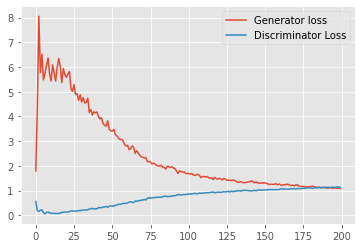

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
plt.figure()
plt.plot(losses_gen, label='Generator loss')
plt.plot(losses_dis, label='Discriminator Loss')
plt.legend()


**Generate fake image using trained generator**

In [ ]:
#sample size to generate a noise
sample_size = 64 
noise = create_noise(sample_size, noise_vec_size)

In [ ]:
#shape of the noise
noise.shape

torch.Size([64, 128])

In [ ]:
generator_model = generator(noise_vec_size)

In [ ]:
#load the trained model
generator_model.load_state_dict(torch.load("model/generator.pth"))
generator_model.eval()
generator_model.to(device)

generator(
  (generator_layer): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [ ]:
#generated image
generated_img=generator_model(noise).detach()
generated_img.shape

torch.Size([64, 1, 28, 28])

In [ ]:
#save the generated image
generated_img = make_grid(generated_img)
save_image(generated_img,"output_img/gen_img.png")